# Series de tiempo y modelos de pronóstico de ventas

---

# Warnings y Librerias

In [1]:
# Omitamos los Warnings:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Ignorar específicamente los warnings de convergencia de statsmodels
warnings.simplefilter("ignore", ConvergenceWarning)

In [2]:
# Librerías Organizadas por Tipo

## **Manipulación y Análisis de Datos** 🧮
import numpy as np  # Librería para cálculos numéricos y científicos (álgebra lineal, etc.).
import pandas as pd  # Librería para manipulación y análisis de datos (DataFrames, Series).

## **Visualización de Datos** 📊
import matplotlib.pyplot as plt  # Generación de gráficos estáticos, interactivos y animados.
import matplotlib.dates as mdates  # Funciones y clases para el manejo de fechas en gráficos de Matplotlib.

## **Evaluación de Modelos** 📈
from sklearn.preprocessing import MinMaxScaler  # Escalado de datos (normalización Min-Max).
from sklearn.metrics import mean_squared_error  # Cálculo del error cuadrático medio (MSE).
import math  # Módulo de funciones matemáticas estándar (sqrt, sin, cos, etc.).

## **Modelado de Series Temporales** ⏳
from prophet import Prophet  # Modelado de series temporales con Prophet de Facebook.
from statsmodels.tsa.arima.model import ARIMA  # Modelos ARIMA y SARIMA para pronósticos.

## **Gráficos y Análisis de Series Temporales con Statsmodels** 📉
from statsmodels.graphics.tsaplots import month_plot, quarter_plot  # Visualización de patrones estacionales mensuales y trimestrales.
from statsmodels.tsa.seasonal import seasonal_decompose  # Descomposición de series temporales (tendencia, estacionalidad, residuo).
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF).

## **Modelado con Redes Neuronales (LSTM)** 🧠
import tensorflow as tf  # Biblioteca de aprendizaje automático de Google (TensorFlow).
from tensorflow.keras.models import Sequential  # Construcción de modelos de redes neuronales secuenciales.
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization  # Capas para construir modelos LSTM (y otros tipos de redes).

## **Kaggle** 🗄️
import kagglehub  # Interactuar con modelos y datasets de Kaggle.
from kagglehub import KaggleDatasetAdapter  # Adaptador para datasets de Kaggle.

## **Utilidades** 🛠️
import random  # Generación de números aleatorios y operaciones relacionadas.

---
##  Preparacion de Los Datos
###Importamos el Set de Datos

## Dataset de Ventas Mensuales de Champaña Francesa 🍾

### Acerca del Dataset

**Contexto:**

El problema consiste en predecir el número de ventas mensuales de champaña de la marca Perrin Freres (que lleva el nombre de una región de Francia). El dataset proporciona el número de ventas mensuales de champaña desde enero de 1964 hasta septiembre de 1972, es decir, poco menos de 10 años de datos. Los valores representan un recuento de millones de ventas y hay 105 observaciones.

**Acerca de este archivo:**

El dataset proporciona el número de ventas mensuales de champaña desde enero de 1964 hasta septiembre de 1972, o poco menos de 10 años de datos. Los valores son un recuento de *millones* de ventas y hay 105 observaciones.

In [3]:
# Descarga la versión más reciente del dataset de ventas mensuales de champaña francesa.
# Se utiliza la función 'dataset_download' de 'kagglehub' para obtener el dataset.
# El argumento es el identificador del dataset en Kaggle en formato "usuario/nombre-del-dataset".
url = kagglehub.dataset_download("piyushagni5/monthly-sales-of-french-champagne")

# Imprime la ruta a los archivos del dataset descargado.
# Esto es útil para verificar que la descarga fue exitosa y para saber dónde
# se encuentran los archivos en el sistema.
print("Ruta a los archivos del dataset:", url)

# Carga el dataset en un DataFrame de Pandas.
# Se usa la función 'load_dataset' de 'kagglehub', junto con 'KaggleDatasetAdapter.PANDAS',
# para cargar los datos directamente en un DataFrame.
#   - El primer argumento es el adaptador (Pandas en este caso).
#   - El segundo argumento es el identificador del dataset en Kaggle.
#   - El tercer argumento es el nombre del archivo CSV específico dentro del dataset.
# Consulta la documentación para más información sobre el uso de la API:
# https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "piyushagni5/monthly-sales-of-french-champagne",
  "monthly_champagne_sales.csv"
)

# Imprime la forma (shape) del DataFrame.
# Esto muestra el número de filas y columnas (observaciones y variables)
# en el dataset, lo que permite verificar rápidamente la estructura de los datos.
print("Forma del DataFrame (filas, columnas):", df.shape)

100%|██████████| 713/713 [00:00<00:00, 1.18MB/s]

Extracting files...
Ruta a los archivos del dataset: /root/.cache/kagglehub/datasets/piyushagni5/monthly-sales-of-french-champagne/versions/1


Download already complete (1596 bytes).
Forma del DataFrame (filas, columnas): (105, 2)


## Verificamos la Integridad de nuestro Data Frame

In [4]:
#Mostrar las primeras filas del dataframe
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [5]:
#Mostrar las ultimas filas del Data Frame
df.tail()

,Month,Sales
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413
104,1972-09,5877


In [6]:
df.info()   # La columnas que nos interesan son Month y Sales

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   105 non-null    object
 1   Sales   105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [7]:
print(df.columns) #Obteniendo las columnas del DataFrame

Index(['Month', 'Sales'], dtype='object')


In [8]:
# Reseteamos el índice para obtener 'Date' como columna
df = df.reset_index()

# Seleccionamos las columnas 'Month' y 'Sales'
df = df[['Month', 'Sales']]

print(df.columns) #Obteniendo las columnas del DataFrame Nuevamente

Index(['Month', 'Sales'], dtype='object')


### Renombramiento y transformación de columnas del DataFrame

In [9]:
# Se renombran las columnas del DataFrame 'df' para que sigan
# la convención estándar utilizada por Prophet:
#   - La columna de fechas se renombra a 'ds' (datestamp).
#   - La columna de valores (la variable objetivo) se renombra a 'y'.
df.columns = ['ds', 'y']

# Se convierte la columna 'ds' (que ahora contiene las fechas) a tipo datetime.
# Esto es crucial para que Prophet pueda trabajar correctamente con las fechas
# y realizar análisis de series temporales.  pd.to_datetime() es una función
# de Pandas que maneja eficientemente la conversión a datetime, incluso
# si hay diferentes formatos de fecha en la columna.
df['ds'] = pd.to_datetime(df['ds'])

# Se muestran las primeras filas del DataFrame resultante para verificar
# los cambios.  .head() es un método de Pandas que, por defecto, muestra
# las primeras 5 filas.  Esto permite una rápida inspección de los datos.
df.head()

,ds,y
0,1964-01-01,2815
1,1964-02-01,2672
2,1964-03-01,2755
3,1964-04-01,2721
4,1964-05-01,2946


In [10]:
df.info()   # La columnas que nos interesan son Month y Sales

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      105 non-null    datetime64[ns]
 1   y       105 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


## **Agreguemos los Ajustes Usuales en Series de Tiempo:** ⚙️⏱️

In [11]:
# Se crea una copia del DataFrame original 'df' y se asigna a 'df_temp'.
# Esto es una buena práctica para evitar modificar el DataFrame original
# de manera accidental.  .copy() crea una copia *profunda*, lo que significa
# que los cambios en 'df_temp' no afectarán a 'df'.
df_temp = df.copy()

# Se establece la columna 'ds' (que contiene las fechas) como el índice del DataFrame.
# Esto es útil para muchas operaciones de series temporales, como el resampling,
# la visualización y el uso con bibliotecas como statsmodels.
# inplace=True modifica el DataFrame 'df_temp' directamente, en lugar de
# devolver una copia con el índice cambiado.
df_temp.set_index('ds', inplace=True)

# Se muestra el DataFrame 'df_temp'.  Al no especificar .head() o .tail(),
# Pandas mostrará las primeras y últimas filas si el DataFrame es pequeño,
# o un resumen si es grande. Esto permite verificar que el índice se ha
# establecido correctamente y tener una vista general de los datos con
# el nuevo índice.
df_temp

,y
ds,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


In [12]:
# Mostrar los últimos registros del DataFrame
print(df.tail(20))

            ds      y
85  1971-02-01   3162
86  1971-03-01   4286
87  1971-04-01   4676
88  1971-05-01   5010
89  1971-06-01   4874
90  1971-07-01   4633
91  1971-08-01   1659
92  1971-09-01   5951
93  1971-10-01   6981
94  1971-11-01   9851
95  1971-12-01  12670
96  1972-01-01   4348
97  1972-02-01   3564
98  1972-03-01   4577
99  1972-04-01   4788
100 1972-05-01   4618
101 1972-06-01   5312
102 1972-07-01   4298
103 1972-08-01   1413
104 1972-09-01   5877


In [13]:
# Imprime la forma (número de filas y columnas) del DataFrame original
print(f"Shape del Data Frame Original: {df.shape}")

# Imprime la forma (número de filas y columnas) del DataFrame
print(f"Shape del Data Frame Temporal df_temp: {df_temp.shape}")

Shape del Data Frame Original: (105, 2)
Shape del Data Frame Temporal df_temp: (105, 1)


In [14]:
# Ajustemos la frecuencia de los índices, para que el modelo tenga información del período en que
# se encuentran los datos:

df_temp.index  # Observamos que aquí todavía no se tiene información del argumento "freq"

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='ds', length=105, freq=None)

In [15]:
# Intenta inferir la frecuencia.
try:
    df_temp.index = pd.to_datetime(df_temp.index) #asegura que sea datetime
    inferred_freq = pd.infer_freq(df_temp.index) #intenta infereir
    if inferred_freq is not None:
        df_temp.index.freq = inferred_freq
        print(f"Frecuencia inferida: {inferred_freq}")
    else:
        df_temp.index.freq = 'MS'  # Asigna 'MS' si no se puede inferir
        print("No se pudo inferir la frecuencia; asignando 'MS'.")

except ValueError: #Si no se puede convertir a datetime
    df_temp.index.freq = 'MS'
    print("Error al convertir a datetime. Asignando 'MS'.")

df_temp.index

Frecuencia inferida: MS


DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='ds', length=105, freq='MS')

## Particionamiento en conjuntos de entrenamiento y prueba.

In [16]:
# Test contendrá los últimos 12
# porque son fechas que solo contienen el inicio de cada  mes
# y es periodico al mes cada 12 registros

# Conjunto de entrenamiento:
# Se seleccionan todas las filas del DataFrame 'df_temp' *excepto* las últimas 12.
# Esto se logra con el slicing [0:-12, :].
#   - 0:-12  ->  Selecciona desde la primera fila (índice 0) hasta la antepenúltima (índice -12).
#   - :      ->  Selecciona todas las columnas.
# El resultado se asigna a la variable 'train'.
train = df_temp.iloc[0:-12, :]

# Conjunto de prueba:
# Se seleccionan las últimas 12 filas del DataFrame 'df_temp'.
# Esto representa los últimos 12 precios de mercado, que usaremos para evaluar el modelo.
# Se usa el slicing [-12:, :].
#   - -12:  ->  Selecciona desde la fila con índice -12 (antepenúltima) hasta el final.
#   - :      ->  Selecciona todas las columnas.
# El resultado se asigna a la variable 'test'.
test = df_temp.iloc[-12:, :]

In [17]:
print(df.columns) #Obteniendo las columnas del DataFrame Nuevamente

Index(['ds', 'y'], dtype='object')


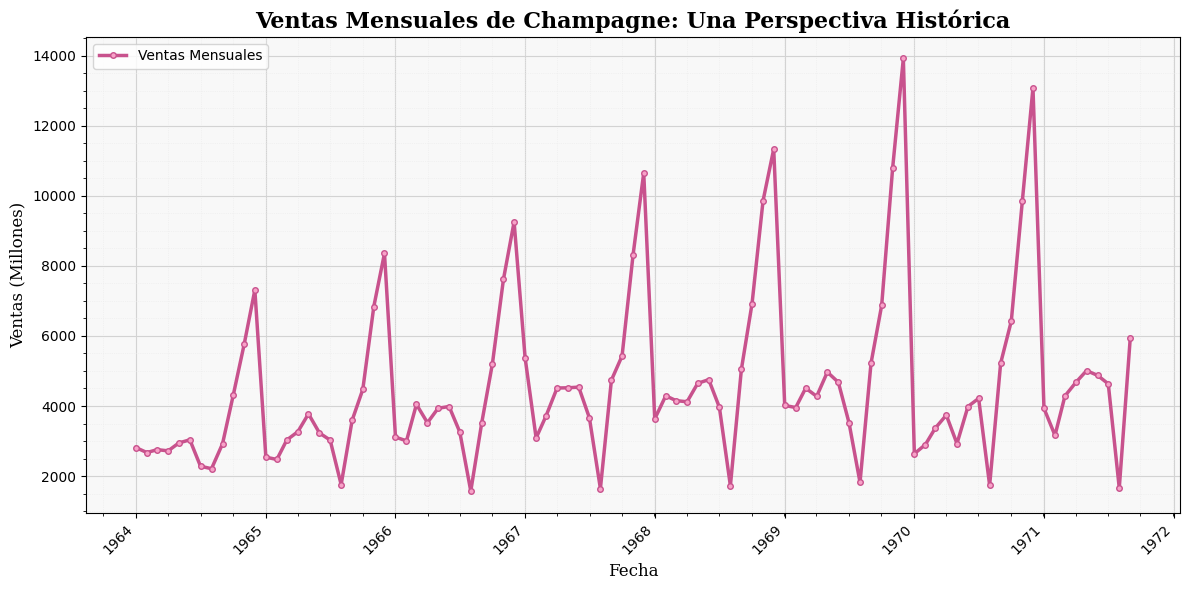

In [18]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))  # Tamaño de figura más grande

# Graficar los datos de entrenamiento
ax.plot(train.index, train['y'], color='#C8528D', linewidth=2.5, label='Ventas Mensuales', marker='o', markersize=4, markerfacecolor='#F8A2C8', markeredgecolor='#C8528D')

# Configurar el título y los ejes
ax.set_title('Ventas Mensuales de Champagne: Una Perspectiva Histórica', fontsize=16, fontweight='bold', fontfamily='serif')
ax.set_xlabel('Fecha', fontsize=12, fontfamily='serif')
ax.set_ylabel('Ventas (Millones)', fontsize=12, fontfamily='serif')

# Formato de las fechas en el eje x
ax.xaxis.set_major_locator(mdates.YearLocator())  # Mostrar etiquetas de año
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato de año (ej. "2023")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # Rotar etiquetas para mejor legibilidad


# Mejorar la apariencia de la cuadrícula
ax.grid(True, which='major', color='#D3D3D3', linestyle='-', linewidth=0.8)  # Líneas más gruesas
ax.grid(True, which='minor', color='#EBEBEB', linestyle=':', linewidth=0.5)  # Líneas punteadas más sutiles
ax.minorticks_on() # Activar las marcas menores

# Añadir leyenda
ax.legend(loc='upper left', fontsize=10)

# Ajustar el espaciado
plt.tight_layout()

# Cambiar el color de fondo
ax.set_facecolor('#F8F8F8')  # Fondo gris muy claro

# Mostrar el gráfico
plt.show()

## Análisis del Gráfico de Ventas Mensuales de Champaña

El gráfico presenta el historial de ventas mensuales de champaña, expresadas en millones, desde 1964 hasta 1972. A partir de la visualización, podemos identificar varias características clave:

*   **Tendencia General:** Se observa una ligera tendencia alcista en las ventas a lo largo del período.  Aunque hay fluctuaciones, en general, las ventas en 1972 son mayores que en 1964.

*   **Estacionalidad Marcada:**  Existe un patrón estacional muy pronunciado que se repite anualmente.  Las ventas muestran picos significativos alrededor de los meses de fin de año (probablemente noviembre y diciembre, coincidiendo con las festividades) y valles en los primeros meses del año.  Esta estacionalidad es el patrón más evidente en los datos.

*   **Ciclos:** Además de la estacionalidad anual, se aprecian ciclos más largos, donde hay años con ventas consistentemente más altas o más bajas que el promedio. Por ejemplo, se aprecian picos mayores al rededor de 1970.

*   **Variabilidad:** La amplitud de las fluctuaciones estacionales (la diferencia entre los picos y los valles) parece aumentar ligeramente con el tiempo. Esto sugiere que la variabilidad de las ventas también podría estar creciendo.

* **Outliers**: No se indentifican outliers, o datos atípicos.

En resumen, el gráfico revela una serie temporal con una leve tendencia creciente, una fuerte estacionalidad anual y cierta variabilidad.  Estas características son fundamentales para elegir y ajustar modelos de pronóstico adecuados.  Un modelo que ignore la estacionalidad, por ejemplo, tendrá un rendimiento muy pobre en estos datos.

---

# **Modelo ingenuo (Baseline / Persistance / Naive model)**

*   El modelo ingenuo simplemente hace la predicción del siguiente perídodo, repitiendo el valor del último período.

*   Este modelo se utiliza en general como punto de partida para comparar todos los demás,

*   Utilicemos el error RMSE (Raíz del Error Cuadrático Medio) como medida del desempeño de nuestros modelos a obtener.

In [19]:
# Se obtiene el histórico de ventas del conjunto de entrenamiento.
# 'history' es una lista que inicialmente contiene los valores de la serie temporal
# de entrenamiento ('y').  Esta lista se usará para el pronóstico "ingenuo".
history = [x for x in train['y'].values]

# Se inicializa una lista vacía para almacenar las predicciones.
predictions = list()

# Se itera sobre cada punto de tiempo en el conjunto de prueba.
for i in range(len(test['y'])):
  # Predicción "ingenua": se usa el valor más reciente disponible en 'history'.
  # En la primera iteración, es el último valor del conjunto de entrenamiento.
  # En iteraciones posteriores, son los valores del conjunto de prueba
  # que se van agregando a 'history'.
  yhat = history[-1]
  predictions.append(yhat)

  # Se obtiene el valor real (observado) del conjunto de prueba en el tiempo actual.
  obs = test.iloc[i]['y']
  # Se agrega el valor real a 'history'.  De esta forma, el modelo "ingenuo"
  # siempre predice el último valor observado.
  history.append(obs)
  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))


# Se calcula la raíz del error cuadrático medio (RMSE) para evaluar el modelo.
rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
print('\nError-Modelo-Naive: RMSE: %.3f' % rmse)
rmse_ingenuo = rmse

>Esperado-real = 6981, Predicción = 5951.000
>Esperado-real = 9851, Predicción = 6981.000
>Esperado-real = 12670, Predicción = 9851.000
>Esperado-real = 4348, Predicción = 12670.000
>Esperado-real = 3564, Predicción = 4348.000
>Esperado-real = 4577, Predicción = 3564.000
>Esperado-real = 4788, Predicción = 4577.000
>Esperado-real = 4618, Predicción = 4788.000
>Esperado-real = 5312, Predicción = 4618.000
>Esperado-real = 4298, Predicción = 5312.000
>Esperado-real = 1413, Predicción = 4298.000
>Esperado-real = 5877, Predicción = 1413.000

Error-Modelo-Naive: RMSE: 3135.480


## Resultados del Modelo Ingenuo (Naive)

El modelo ingenuo, que simplemente predice el valor del mes anterior, presenta un RMSE de 3135.480.  Cada línea muestra el valor real y la predicción del modelo.  Se observa cómo la predicción siempre va un paso por detrás del valor real.

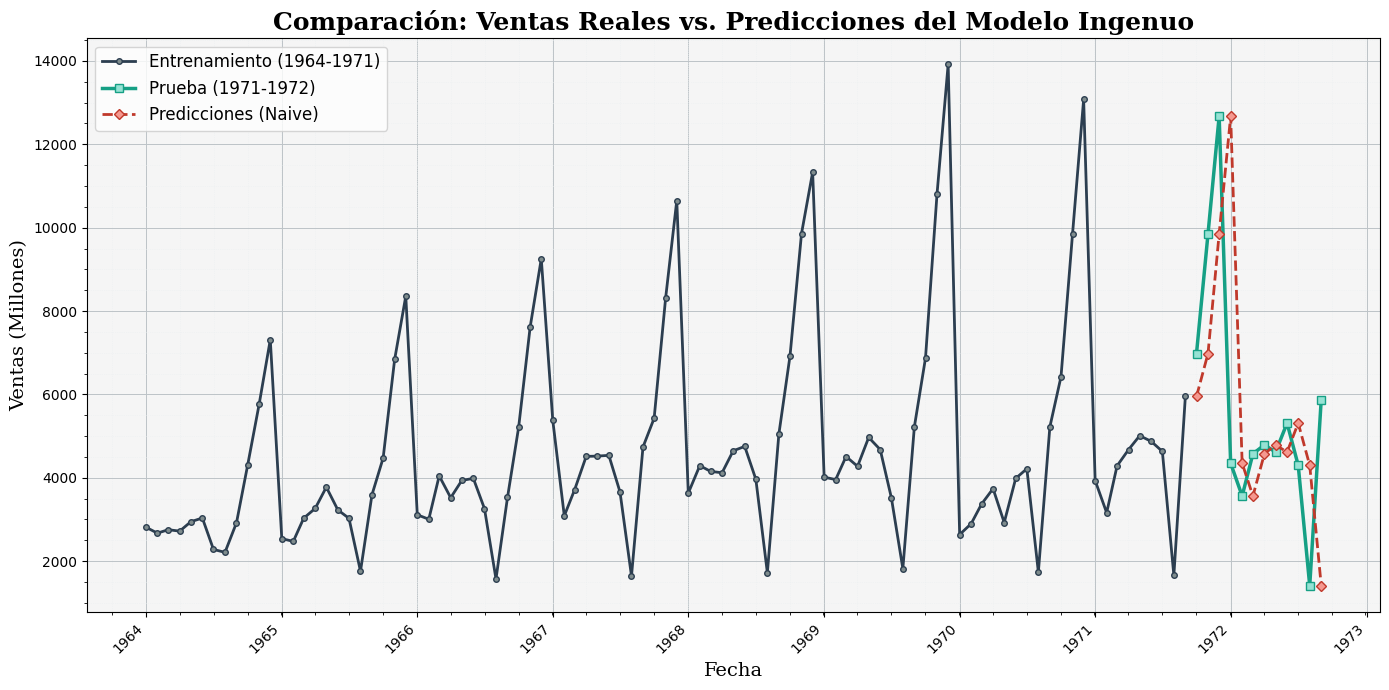

In [20]:
# Crear la figura y los ejes con un tamaño más grande
fig, ax = plt.subplots(figsize=(14, 7))

# Graficar los datos de entrenamiento
ax.plot(train.index, train['y'], color='#2c3e50', linewidth=2, label='Entrenamiento (1964-1971)', marker='o', markersize=4, markerfacecolor='#7f8c8d', markeredgecolor='#2c3e50')

# Graficar los datos de prueba (reales)
ax.plot(test.index, test['y'], color='#16a085', linewidth=2.5, label='Prueba (1971-1972)', marker='s', markersize=6, markerfacecolor='#96E2D4',markeredgecolor='#16a085')

# Graficar las predicciones del modelo ingenuo
ax.plot(test.index, predictions, color='#c0392b', linewidth=2, label='Predicciones (Naive)', marker='D', markersize=5, markerfacecolor='#F5988F', markeredgecolor='#c0392b', linestyle='--')


# Configurar el título y las etiquetas de los ejes
ax.set_title('Comparación: Ventas Reales vs. Predicciones del Modelo Ingenuo', fontsize=18, fontweight='bold', fontfamily='serif')
ax.set_xlabel('Fecha', fontsize=14, fontfamily='serif')
ax.set_ylabel('Ventas (Millones)', fontsize=14, fontfamily='serif')

# Formato de las fechas en el eje x (mostrar años)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # Rotar etiquetas

# Mejorar la cuadrícula
ax.grid(True, which='major', color='#bdc3c7', linestyle='-', linewidth=0.7)
ax.grid(True, which='minor', color='#ecf0f1', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Añadir leyenda con ubicación específica y tamaño de fuente
ax.legend(loc='upper left', fontsize=12)

# Ajustar el espaciado para evitar cortes de etiquetas
plt.tight_layout()

# Establecer un color de fondo sutil
ax.set_facecolor('#f5f5f5')

# Mostrar el gráfico
plt.show()

## A pesar de que las predicciones puedan parecer visualmente cercanas a los valores reales en el gráfico, es crucial observar que, en realidad, existe un desfase sistemático de **un mes**. El modelo ingenuo simplemente replica el valor del mes anterior, generando este retraso inherente.

---

# **Modelo ARIMA**

### ARIMA es un modelo estadístico que utiliza componentes autorregresivas y de media móvil para modelar series de tiempo.

### **Análisis preliminar para obtener información de la serie de tiempo y construir el modelo ARIMA(p,d,q).**

*   **AR (AutoRegresivo):** El modelo se basa en la relación entre un valor actual y sus valores pasados.

*   **I (Integrado):** Se refiere a la diferenciación de la serie para hacerla estacionaria, es decir, eliminar tendencias y patrones cíclicos.

*   **MA (Media Móvil):** Usa el error de los valores pasados (las desviaciones entre valores predichos y observados) para corregir el valor actual.

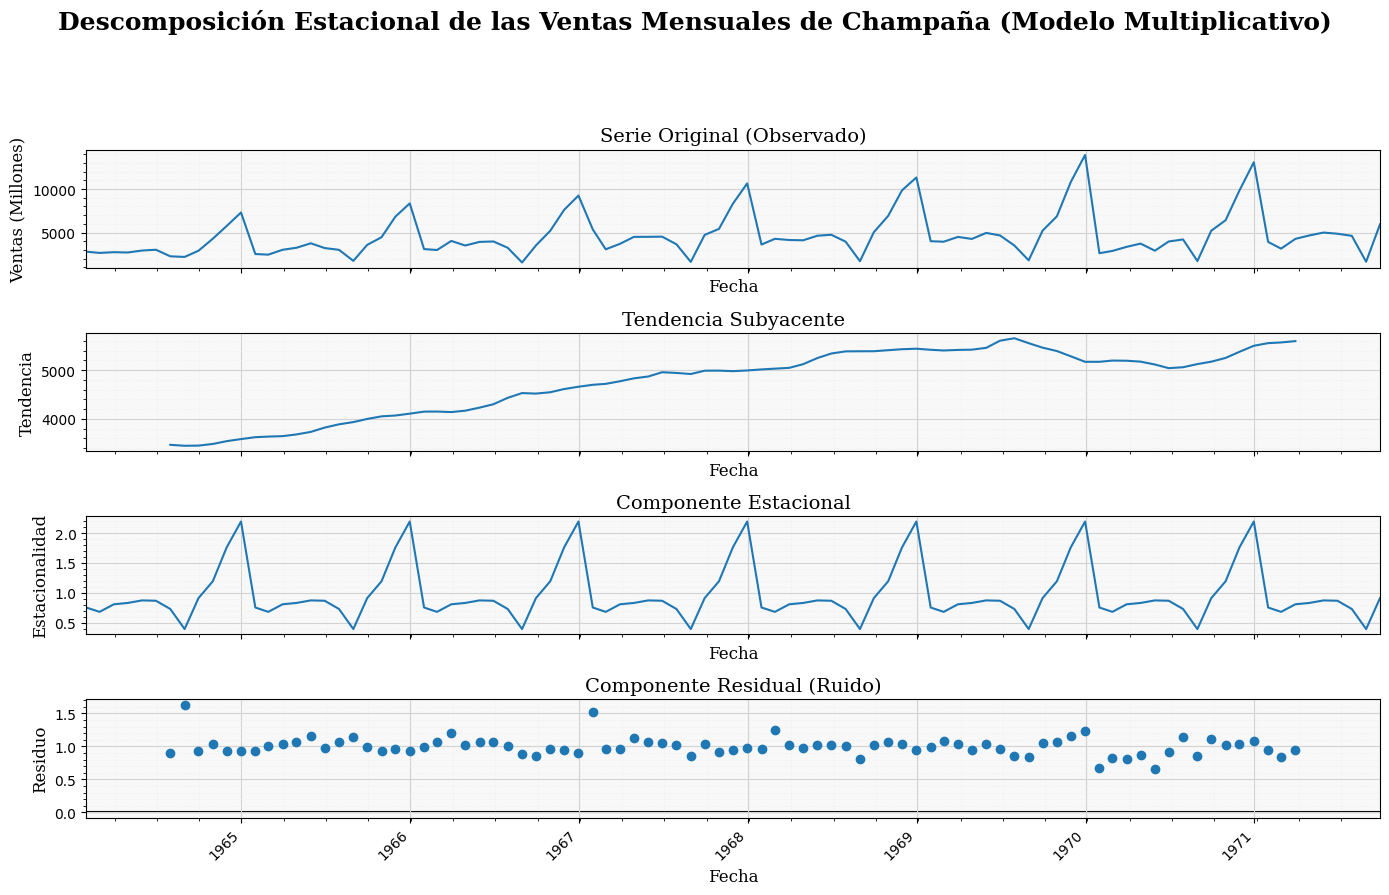

In [21]:
# Descomposición estacional con un modelo multiplicativo.
# Se realiza un resampling de los datos a frecuencia mensual ('M') y se calcula la media
# para obtener una representación más clara de la tendencia y la estacionalidad.
decomposition = seasonal_decompose(train['y'].resample('M').mean(), model='multiplicative')

# Graficamos la descomposición estacional.
fig = decomposition.plot()

# Ajustamos el tamaño del gráfico para una mejor visualización.
fig.set_size_inches(14, 9)  # Tamaño más grande

# Mejoramos el gráfico con un título principal más descriptivo y estilizado.
fig.suptitle('Descomposición Estacional de las Ventas Mensuales de Champaña (Modelo Multiplicativo)', fontsize=18, fontweight='bold', fontfamily='serif', y=1.02)

# Añadimos títulos y etiquetas descriptivas a cada subgráfico para mayor claridad.
# Se especifica la unidad de medida (Millones) en el eje Y del primer subgráfico.
fig.axes[0].set_ylabel("Ventas (Millones)", fontsize=12, fontfamily='serif')
fig.axes[0].set_title("Serie Original (Observado)", fontsize=14, fontfamily='serif')

fig.axes[1].set_ylabel("Tendencia", fontsize=12, fontfamily='serif')
fig.axes[1].set_title("Tendencia Subyacente", fontsize=14, fontfamily='serif')

fig.axes[2].set_ylabel("Estacionalidad", fontsize=12, fontfamily='serif')
fig.axes[2].set_title("Componente Estacional", fontsize=14, fontfamily='serif')

fig.axes[3].set_ylabel("Residuo", fontsize=12, fontfamily='serif')
fig.axes[3].set_title("Componente Residual (Ruido)", fontsize=14, fontfamily='serif')

#Establecer formato de fechas para todos los subplots

for ax in fig.axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # Rotar etiquetas
    ax.grid(True, which='major', color='#D3D3D3', linestyle='-', linewidth=0.8)
    ax.grid(True, which='minor', color='#EBEBEB', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    ax.set_facecolor('#F8F8F8') #Background color
    ax.tick_params(axis='x', labelsize=10) #x labels font size
    ax.tick_params(axis='y', labelsize=10) #y labels font size
    ax.set_xlabel("Fecha",fontsize=12, fontfamily='serif') #Adds x label

# Ajustamos el espaciado para evitar solapamientos y asegurar que el título no se superponga.
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste fino del espaciado

# Mostrar el gráfico.
plt.show()

### Análisis de los Residuos 🧐

Un punto crucial a destacar en el gráfico de residuos es que estos se distribuyen alrededor de 1, en lugar de centrarse alrededor de 0 como se observaría comúnmente en un modelo aditivo. Esta característica es una consecuencia directa de haber utilizado un modelo de descomposición *multiplicativo*. En un modelo multiplicativo, los residuos representan la *proporción* entre el valor observado y el valor ajustado (tendencia * estacionalidad), por lo que un valor residual cercano a 1 indica que la predicción del modelo está cerca del valor real. Un residuo de, por ejemplo, 1.1 indica que el valor real fue un 10% superior a la predicción del modelo, mientras que un valor de 0.9 significaría un 10% por debajo. En cambio, con un modelo aditivo los residuos si deben estar centrados en cero, pues representan la diferencia.

## Verifiquemos Estacionalidad Mensual o Trimestral

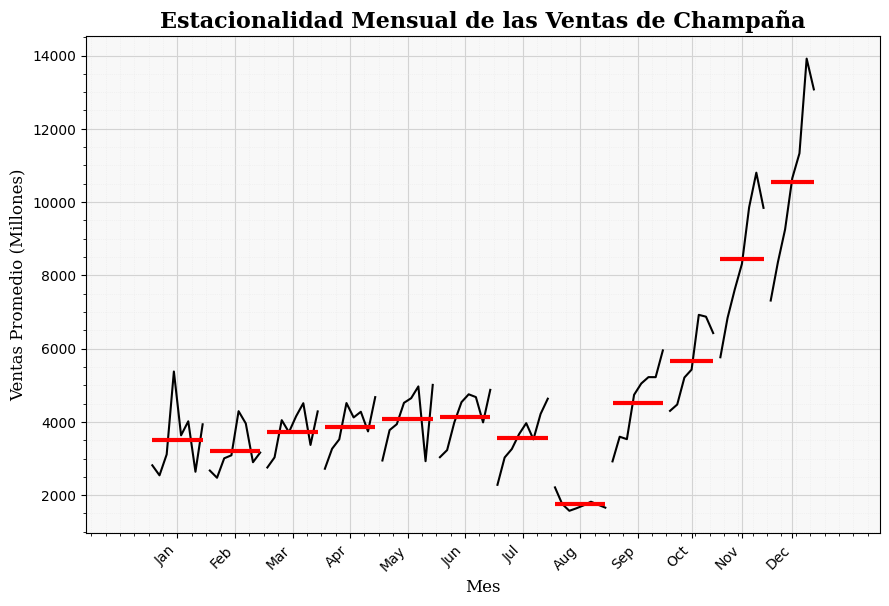

In [22]:
# Gráfico para la detección de estacionalidad mensual.
# Se utiliza la función 'month_plot' de 'statsmodels.graphics.tsaplots'.

# Se realiza un resampling de los datos de entrenamiento ('train['y']') a frecuencia de fin de mes ('ME')
# y se calcula la media de las ventas para cada mes.  Esto agrega los datos por mes
# a través de los años, permitiendo visualizar el patrón estacional promedio.
fig, ax = plt.subplots(figsize=(9, 6))  # Increased figure size

month_plot(train['y'].resample('ME').mean(), ylabel='Ventas (Millones)', ax=ax)

# Configurar el título y los ejes
ax.set_title('Estacionalidad Mensual de las Ventas de Champaña', fontsize=16, fontweight='bold', fontfamily='serif')
ax.set_xlabel('Mes', fontsize=12, fontfamily='serif')
ax.set_ylabel('Ventas Promedio (Millones)', fontsize=12, fontfamily='serif') #Added average

# Mejorar la apariencia de la cuadrícula
ax.grid(True, which='major', color='#D3D3D3', linestyle='-', linewidth=0.8)
ax.grid(True, which='minor', color='#EBEBEB', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Ajustar el espaciado
plt.tight_layout()

# Cambiar el color de fondo
ax.set_facecolor('#F8F8F8')  # Fondo gris muy claro

# Rotar las etiquetas del eje x para mayor claridad
plt.xticks(rotation=45, ha='right')


# Mostrar el gráfico.
plt.show()

## Análisis del Gráfico de Estacionalidad Mensual

El gráfico de estacionalidad mensual muestra el promedio de ventas de champaña para cada mes, calculado a partir de los datos históricos de entrenamiento. Este tipo de gráfico es una herramienta muy útil para visualizar patrones estacionales dentro de una serie temporal.  Cada punto en la línea negra representa la media de las ventas de todos los eneros, todos los febreros, etc., a lo largo de los años del conjunto de entrenamiento. Las barras rojas horizontales dentro de cada mes, unen los valores máximos con los mínimos y representan el rango de variación de las ventas para ese mes en particular.

**Observaciones Clave:**

*   **Pico en Diciembre:** Se observa un pico muy pronunciado en las ventas promedio de diciembre. Esto es consistente con la estacionalidad observada en el gráfico de la serie temporal completa, y confirma que las festividades de fin de año (Navidad y Año Nuevo) impulsan fuertemente las ventas de champaña.

*   **Valle en Enero-Febrero:** Después del pico de diciembre, las ventas caen drásticamente en enero y febrero. Esto es de esperar, ya que la demanda disminuye considerablemente después de las festividades.

*   **Incremento Gradual:**  A partir de marzo, se observa un incremento gradual en las ventas promedio a medida que avanza el año, culminando en el pico de diciembre. Este patrón sugiere un aumento de la demanda a medida que se acercan las festividades.

* **Rango**: El rango de variación (barras rojas) nos indica que tan estables son las ventas para un mes en particular. Como podemos ver Diciembre, aparte de ser el mes con mayores ventas en promedio, también presenta la variación mas grande.

**Implicaciones para el Modelado:**

Este gráfico refuerza la importancia de considerar la estacionalidad mensual al construir un modelo de pronóstico para las ventas de champaña.  Un modelo que no tenga en cuenta este patrón estacional tendrá un rendimiento significativamente peor que un modelo que sí lo haga.  Modelos como ARIMA (con componentes estacionales), Prophet y LSTM (con características de fecha adecuadas) son capaces de capturar esta estacionalidad. El modelo ingenuo, por el contrario, fallará completamente en predecir estos picos y valles mensuales.

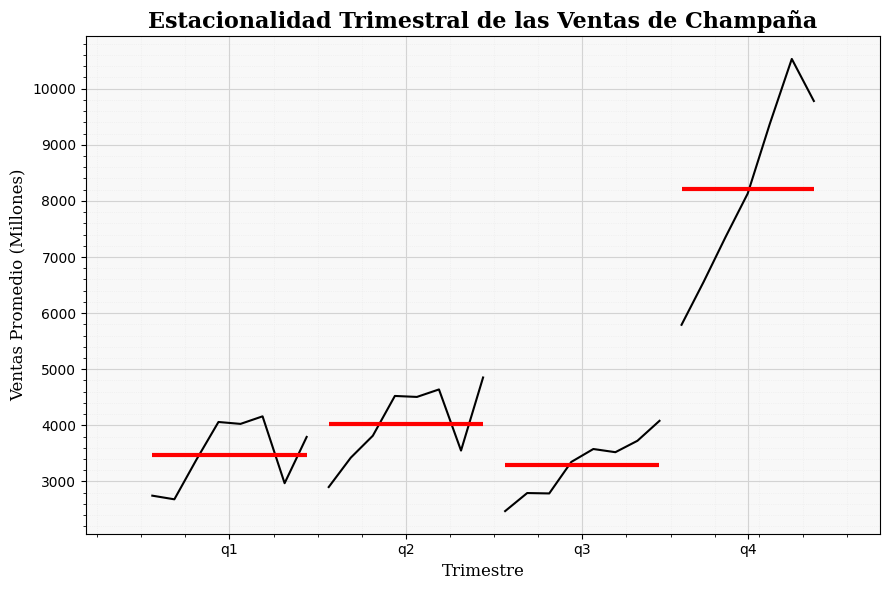

In [23]:
# Gráfico para la detección de estacionalidad trimestral.
# Se utiliza la función 'quarter_plot' de 'statsmodels.graphics.tsaplots'.

# Se realiza un resampling de los datos de entrenamiento ('train['y']') a frecuencia de fin de trimestre ('QE')
# y se calcula la media de las ventas para cada trimestre. Esto agrega los datos por trimestre
# a través de los años, permitiendo visualizar el patrón estacional trimestral promedio.
fig, ax = plt.subplots(figsize=(9, 6))  # Increased figure size

quarter_plot(train['y'].resample('QE').mean(), ylabel='Ventas (Millones)', ax=ax)

# Configurar el título y los ejes
ax.set_title('Estacionalidad Trimestral de las Ventas de Champaña', fontsize=16, fontweight='bold', fontfamily='serif')
ax.set_xlabel('Trimestre', fontsize=12, fontfamily='serif')
ax.set_ylabel('Ventas Promedio (Millones)', fontsize=12, fontfamily='serif') #Added average

# Mejorar la apariencia de la cuadrícula
ax.grid(True, which='major', color='#D3D3D3', linestyle='-', linewidth=0.8)
ax.grid(True, which='minor', color='#EBEBEB', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Ajustar el espaciado
plt.tight_layout()

# Cambiar el color de fondo
ax.set_facecolor('#F8F8F8')  # Fondo gris muy claro

# Mostrar el gráfico.
plt.show()

## Análisis del Gráfico de Estacionalidad Trimestral

El gráfico de estacionalidad trimestral muestra las ventas promedio de champaña para cada uno de los cuatro trimestres del año (Q1, Q2, Q3, Q4), calculadas a partir de los datos históricos. La línea negra conecta los promedios de cada trimestre, mientras las barras rojas horizontales indican el rango (valores máximos y mínimos).

**Observaciones Principales:**

*   **Fuerte Pico en Q4:**  Se observa un incremento dramático en las ventas promedio durante el cuarto trimestre (Q4), que corresponde a los meses de octubre, noviembre y diciembre. Esto confirma, a nivel trimestral, la fuerte influencia de las festividades de fin de año en la demanda de champaña.

*   **Ventas Bajas en Q1 y Q3:** El primer trimestre (Q1: enero-marzo) y el tercer trimestre (Q3: julio, agosto, septiembre) muestran ventas promedio significativamente menores. Q1 es bajo debido al descenso después de las festividades, y Q3 por no tener festivos importantes.

* **Ligero Aumento Q2:** Hay un ligero aumento en el Q2, aunque el crecimiento no es tan drástico.

*   **Rango:** El rango de variación (barras rojas) son mayores en Q2 y, sobre todo, Q4.

**Conclusión:**

El patrón trimestral refuerza la conclusión de la fuerte estacionalidad anual, con un claro dominio del cuarto trimestre.  Cualquier modelo de pronóstico debe capturar este patrón trimestral para ser preciso.

---
### **Gráficos de Autocorrelación (ACF) y Autocorrelación Parcial (PACF)** 📈

*   **ACF:** Mide la correlación total (directa e indirecta) entre una serie temporal y sus versiones rezagadas.
*   **PACF:** Mide la correlación directa entre una serie temporal y sus rezagos, eliminando efectos intermedios.
*   El eje horizontal muestra el *lag* (desfase) y el vertical, la correlación.
*   El área sombreada representa el intervalo de confianza (95% por defecto).
*   Autocorrelaciones significativas fuera del intervalo indican que la serie no es aleatoria.
*   En estos "lollipop plots", ¿cuántos "lollipops" (sin contar el inicial) se salen del intervalo antes de que el siguiente entre?

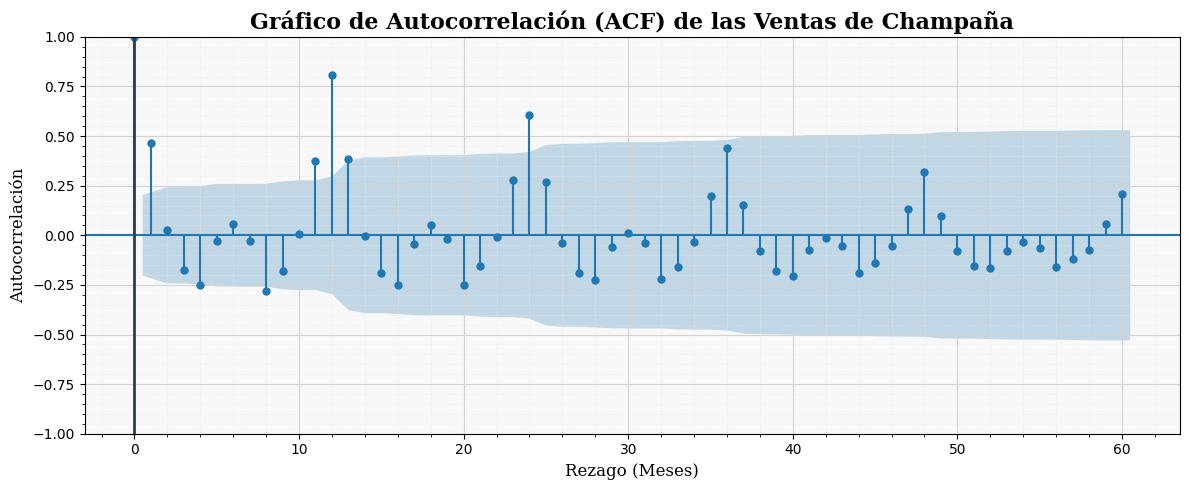

In [24]:
# Gráfico de Autocorrelación (ACF: Auto-Correlation Function).
# El ACF muestra la correlación entre una serie temporal y sus versiones rezagadas.
# Es útil para identificar la presencia de autocorrelación y determinar el orden de un modelo MA (Moving Average).

fig, ax = plt.subplots(figsize=(12, 5))  # Increased figure size

# Se genera el gráfico ACF utilizando la función 'plot_acf' de 'statsmodels.graphics.tsaplots'.
#   - train['y']:  La serie temporal de ventas (columna 'y' del DataFrame 'train').
#   - lags=60:     Especifica el número máximo de rezagos (lags) a considerar.  60 meses = 5 años.
#   - ax=ax:       Indica que el gráfico se dibuje en el objeto 'ax' creado anteriormente.
plot_acf(train['y'], lags=60, ax=ax, title='Gráfico de Autocorrelación (ACF)')

# Personalización del gráfico:

# Título y etiquetas de los ejes
ax.set_title('Gráfico de Autocorrelación (ACF) de las Ventas de Champaña', fontsize=16, fontweight='bold', fontfamily='serif')
ax.set_xlabel('Rezago (Meses)', fontsize=12, fontfamily='serif')
ax.set_ylabel('Autocorrelación', fontsize=12, fontfamily='serif')

# Mejorar la apariencia de la cuadrícula
ax.grid(True, which='major', color='#D3D3D3', linestyle='-', linewidth=0.8)
ax.grid(True, which='minor', color='#EBEBEB', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Ajustar el espaciado
plt.tight_layout()

# Cambiar el color de fondo
ax.set_facecolor('#F8F8F8')  # Fondo gris muy claro
#Se agrega una lina vertical en el x=0
ax.axvline(x=0, color='#2c3e50', linestyle='-', linewidth=2)

# Mostrar el gráfico.
plt.show()

# Interpretación:
#   - El área sombreada representa el intervalo de confianza (generalmente 95%).
#   - Los picos que sobresalen del área sombreada indican autocorrelaciones significativas.
#   - Un patrón repetitivo en el ACF (como el que se observa aquí) sugiere estacionalidad.
#   - La autocorrelación significativa en el lag 12 indica una fuerte estacionalidad anual (cada 12 meses).

## Análisis del Gráfico de Autocorrelación (ACF)

El gráfico ACF muestra una fuerte autocorrelación positiva en el rezago 12, lo que confirma la estacionalidad anual de las ventas de champaña.  También se observan autocorrelaciones significativas en múltiplos de 12 (24, 36, etc.), aunque van decayendo.  Otros rezagos, como el 1, también presentan autocorrelación significativa, lo que sugiere que los valores de ventas también están correlacionados con los valores de meses inmediatamente adyacentes. La presencia de estas autocorrelaciones indica que la serie no es aleatoria y que un modelo de series temporales puede ser apropiado.

In [25]:
# Función para diferenciar una serie temporal y eliminar la estacionalidad.
# Transforma un problema no estacionario (SARIMA) en uno estacionario (ARIMA).
def difference(dataset, interval=1):
  """
  Calcula la diferencia de una serie temporal para eliminar la estacionalidad.

  Args:
    dataset: La serie temporal (lista o array de NumPy).
    interval: El intervalo de diferenciación (lag).  Por defecto es 1 (diferencia simple).
              Si interval=12, se calcula la diferencia estacional (para datos mensuales).

  Returns:
    Un array de NumPy que contiene la serie temporal diferenciada.
  """
  diff = list()  # Inicializa una lista vacía para almacenar las diferencias.

  # Itera sobre la serie temporal, comenzando en el índice 'interval'.
  for i in range(interval, len(dataset)):
    # Calcula la diferencia entre el valor actual y el valor 'interval' posiciones atrás.
    value = dataset[i] - dataset[i - interval]
    diff.append(value)  # Agrega la diferencia calculada a la lista 'diff'.

  return np.array(diff)  # Convierte la lista de diferencias a un array de NumPy y lo devuelve.


# Función para invertir la diferenciación y recuperar la escala original de la serie temporal.
def inverse_difference(history, yhat, interval=1):
  """
  Invierte la diferencia de una serie temporal.

  Args:
    history: La serie temporal original (o la serie con menos diferenciaciones).
             Se utiliza para obtener los valores necesarios para revertir la diferencia.
    yhat:    El valor predicho de la serie diferenciada.
    interval: El intervalo de diferenciación que se utilizó originalmente.

  Returns:
    El valor predicho en la escala original (sin diferenciar).
  """
  return yhat + history[-interval] # Suma la predicción a el valor de history con el intervalo dado.

In [26]:
# Crea una lista de números enteros desde 0 (inclusive) hasta 2 (exclusive).
# La función 'range(0, 2)' genera una secuencia de números [0, 1].
# La list comprehension '[x for x in range(0, 2)]' itera a través de esta secuencia
# y crea una nueva lista que contiene los mismos valores.
q = [x for x in range(0, 2)]

# Imprime la lista 'q'.  El resultado será [0, 1].
q

[0, 1]

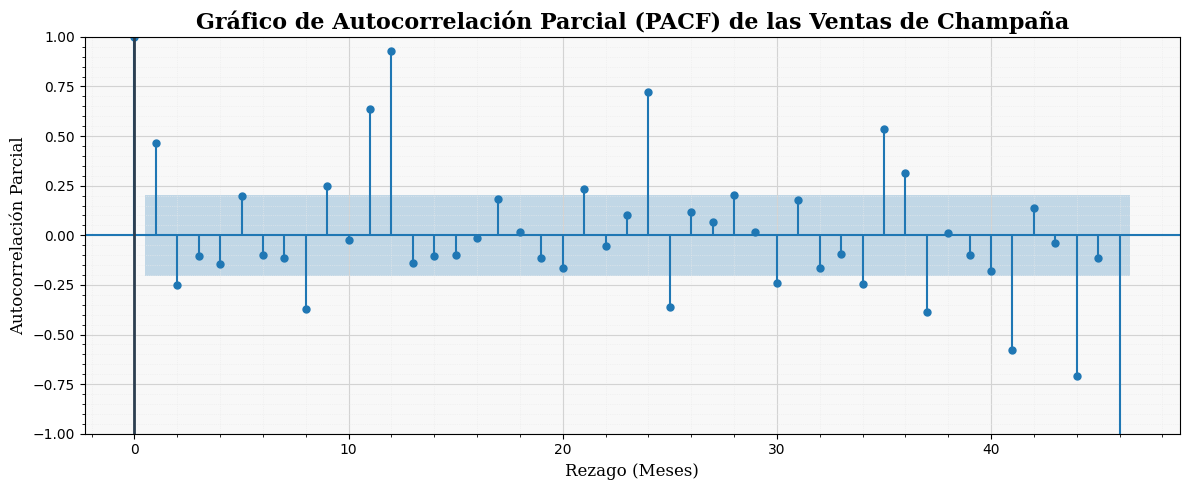

In [27]:
# Gráfico de Autocorrelación Parcial (PACF).
# El PACF muestra la correlación directa entre una serie temporal y sus rezagos,
# eliminando los efectos de los rezagos intermedios.
# Es útil para identificar el orden de un modelo AR (Autoregressive).

fig, ax = plt.subplots(figsize=(12, 5))  # Increased figure size for better readability

# Se genera el gráfico PACF utilizando la función 'plot_pacf' de 'statsmodels.graphics.tsaplots'.
#   - train['y']: La serie temporal de ventas (columna 'y' del DataFrame 'train').
#   - lags=46:    Especifica el número máximo de rezagos (lags) a considerar.
#   - ax=ax:      Indica que el gráfico se dibuje en el objeto 'ax' creado anteriormente.
#   - method="ols": Especifica el método para calcular la autocorrelación parcial.
#                   'ols' (Ordinary Least Squares) es una opción común y adecuada para muchas series temporales.
#                   El método predeterminado es 'ywm' (Yule-Walker), que puede ser menos preciso en algunos casos.
plot_pacf(train['y'], lags=46, ax=ax, method="ols", title='Gráfico de Autocorrelación Parcial (PACF)')

# Personalización del gráfico:

# Título y etiquetas de los ejes
ax.set_title('Gráfico de Autocorrelación Parcial (PACF) de las Ventas de Champaña', fontsize=16, fontweight='bold', fontfamily='serif')
ax.set_xlabel('Rezago (Meses)', fontsize=12, fontfamily='serif')
ax.set_ylabel('Autocorrelación Parcial', fontsize=12, fontfamily='serif')

# Mejorar la apariencia de la cuadrícula
ax.grid(True, which='major', color='#D3D3D3', linestyle='-', linewidth=0.8)
ax.grid(True, which='minor', color='#EBEBEB', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Ajustar el espaciado
plt.tight_layout()

# Cambiar el color de fondo
ax.set_facecolor('#F8F8F8')  # Fondo gris muy claro

# Se agrega una linea vertical
ax.axvline(x=0, color='#2c3e50', linestyle='-', linewidth=2)
# Mostrar el gráfico.
plt.show()

# Interpretación:
#   - El área sombreada representa el intervalo de confianza (generalmente 95%).
#   - Los picos que sobresalen del área sombreada indican autocorrelaciones parciales significativas.
#   - En un modelo AR(p), el PACF "corta" después del lag p (es decir, las autocorrelaciones parciales son cercanas a cero).
#   - En este caso, se observa una autocorrelación parcial significativa en el lag 1, y posiblemente en los lags 2 y 12.

## Análisis del Gráfico de Autocorrelación Parcial (PACF)

El gráfico PACF muestra las autocorrelaciones parciales de las ventas de champaña para diferentes rezagos (lags).  A diferencia del ACF, el PACF elimina los efectos de los rezagos intermedios, mostrando la correlación *directa* entre la serie y un rezago específico.

**Observaciones Clave:**

*   **Rezago 1 Significativo:** Se observa una autocorrelación parcial positiva y significativa en el rezago 1. Esto indica una fuerte relación directa entre las ventas de un mes y las del mes anterior.
*   **Rezago 12 Significativo:** Hay un pico positivo significativo en el rezago 12, lo que refuerza la estacionalidad anual. Esto sugiere que las ventas de un mes están correlacionadas con las ventas del mismo mes del año anterior, *incluso después de tener en cuenta la influencia de los meses intermedios*.
* **Rezago 2 Significativo:** Tambien se observa que el rezago 2 es significativo.
*   **Otros Rezagos:**  La mayoría de los otros rezagos tienen autocorrelaciones parciales dentro del intervalo de confianza (área sombreada), lo que sugiere que no son significativamente diferentes de cero.  Sin embargo, hay algunos picos pequeños que superan ligeramente los límites, lo que podría indicar alguna estructura adicional en los datos, aunque menos pronunciada que los rezagos 1 y 12.

**Implicaciones para el Modelado:**

El PACF sugiere que un modelo autorregresivo (AR) podría ser apropiado.  El fuerte pico en el rezago 1 sugiere un componente AR(1).  El pico en el rezago 12 sugiere un componente estacional AR(12) o un modelo SARIMA con un componente estacional. Un modelo AR(2) tambien podria ser viable. Una evaluación más completa (por ejemplo, usando criterios de información como AIC o BIC) sería necesaria para determinar el orden óptimo del modelo.

In [28]:
# Crea una lista de números enteros desde 0 (inclusive) hasta 3 (exclusive).
# La función 'range(0, 3)' genera la secuencia de números [0, 1, 2].
# La list comprehension '[x for x in range(0, 3)]' itera sobre esta secuencia
# y crea una nueva lista 'p' que contiene estos mismos valores.
p = [x for x in range(0, 3)]

# Imprime la lista 'p'. El resultado será [0, 1, 2].
p

[0, 1, 2]

In [29]:
# Inicializar la lista 'history' con los valores de la columna 'y' del conjunto de entrenamiento.
# Esta lista se usará para almacenar los datos históricos y actualizar el modelo en cada paso.
history = [x for x in train['y'].values]

# Inicializar una lista vacía para almacenar las predicciones del modelo.
predictions = list()

# Iterar sobre cada observación en el conjunto de prueba.
for i in range(len(test['y'])):
    # Definir el intervalo de diferenciación estacional (12 meses para datos mensuales).
    months_in_year = 12

    # Aplicar la diferenciación estacional a la serie temporal 'history'.
    # Esto ayuda a eliminar la estacionalidad y hacer que la serie sea estacionaria,
    # lo cual es un requisito para los modelos ARIMA.
    diff = difference(history, months_in_year)

    # Crear y ajustar el modelo ARIMA.
    #   - order=(2, 0, 4):  Especifica el orden del modelo ARIMA(p, d, q).
    #     * p = 2: Orden del componente autorregresivo (AR).
    #     * d = 0: Grado de diferenciación (ya se aplicó la diferenciación estacional).
    #     * q = 4: Orden del componente de media móvil (MA).
    #   - method_kwargs={'maxiter': 300}:  Aumenta el número máximo de iteraciones
    #     para el ajuste del modelo, evitando problemas de convergencia.
    model = ARIMA(diff, order=(2, 0, 4))
    model_fit = model.fit(method_kwargs={'maxiter': 300})

    # Realizar la predicción para el siguiente paso de tiempo.
    # 'forecast()' devuelve un array con la predicción; [0] extrae el valor puntual.
    yhat = model_fit.forecast()[0]

    # Invertir la diferenciación estacional para obtener la predicción en la escala original.
    yhat = inverse_difference(history, yhat, months_in_year)

    # Agregar la predicción a la lista de predicciones.
    predictions.append(yhat)

    # Obtener el valor real (observado) del conjunto de prueba.
    obs = test.iloc[i]['y']

    # Agregar el valor real a la lista 'history' para usarlo en la siguiente iteración.
    history.append(obs)

    # Imprimir el valor real y la predicción.
    print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))

# Calcular la raíz del error cuadrático medio (RMSE) para evaluar el modelo.
rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
print('\nError-Modelo-ARIMA: RMSE: %.3f' % rmse)
rmse_arima = rmse

>Esperado-real = 6981, Predicción = 6722.595
>Esperado-real = 9851, Predicción = 9957.144
>Esperado-real = 12670, Predicción = 13328.615
>Esperado-real = 4348, Predicción = 4307.763
>Esperado-real = 3564, Predicción = 3536.214
>Esperado-real = 4577, Predicción = 4412.557
>Esperado-real = 4788, Predicción = 4849.914
>Esperado-real = 4618, Predicción = 5383.138
>Esperado-real = 5312, Predicción = 5223.967
>Esperado-real = 4298, Predicción = 4898.928
>Esperado-real = 1413, Predicción = 1595.407
>Esperado-real = 5877, Predicción = 6011.182

Error-Modelo-ARIMA: RMSE: 359.474


## Resultados del Modelo ARIMA

El modelo ARIMA, tras aplicar diferenciación estacional y ajustar los parámetros (p=2, d=0, q=4), presenta un RMSE de 359.474.  Las líneas de salida muestran el valor real ("Esperado-real") y la predicción del modelo para cada mes del conjunto de prueba. Se puede apreciar que, a diferencia del modelo ingenuo, el modelo ARIMA no presenta un desfase sistemático de un mes, e intenta capturar las fluctuaciones de la serie, logrando en varios casos una predicción cercana. Sin embargo, el modelo no es perfecto, y en algunos casos, la diferencia entre el valor real y la predicción es notable, en especial en los picos.

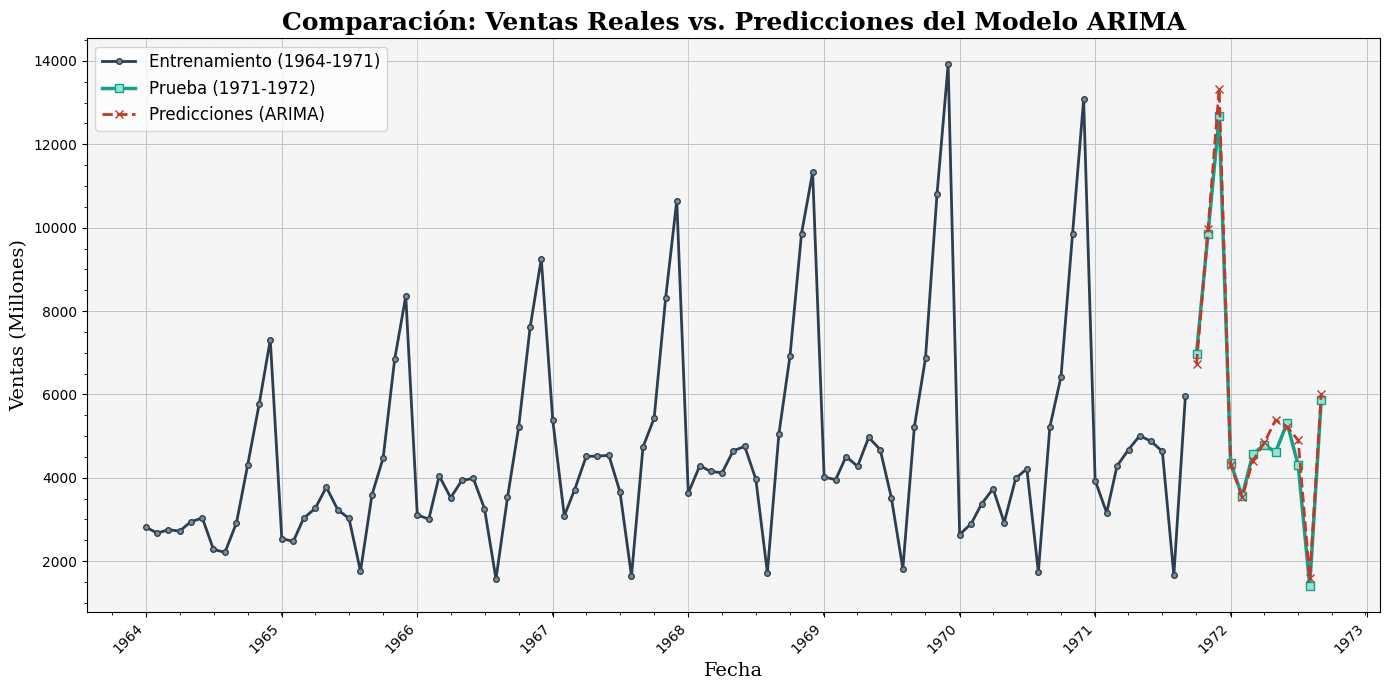

In [30]:
# Crear la figura y los ejes con un tamaño más grande y apaisado
fig, ax = plt.subplots(figsize=(14, 7))

# Graficar los datos de entrenamiento
# Se utiliza una línea sólida negra ('-k') para representar los datos históricos.
# Se añade una etiqueta para la leyenda.
ax.plot(train.index, train['y'], color='#2c3e50', linewidth=2, label='Entrenamiento (1964-1971)', marker='o', markersize=4, markerfacecolor='#7f8c8d', markeredgecolor='#2c3e50')

# Graficar los datos de prueba (reales)
# Se utiliza una línea sólida azul ('-b') para los datos reales del conjunto de prueba.
# Se añade una etiqueta para la leyenda.
ax.plot(test.index, test['y'], color='#16a085', linewidth=2.5, label='Prueba (1971-1972)', marker='s', markersize=6, markerfacecolor='#96E2D4', markeredgecolor='#16a085')

# Graficar las predicciones del modelo ARIMA
# Se utiliza una línea punteada roja ('--r') para las predicciones.
# Se utiliza el marcador 'x' para resaltar los puntos de predicción individuales.
# Se añade una etiqueta para la leyenda.
ax.plot(test.index, predictions, color='#c0392b', linewidth=2, label='Predicciones (ARIMA)', marker='x', markersize=6, linestyle='--')

# Configurar el título y los ejes
ax.set_title('Comparación: Ventas Reales vs. Predicciones del Modelo ARIMA', fontsize=18, fontweight='bold', fontfamily='serif')
ax.set_xlabel('Fecha', fontsize=14, fontfamily='serif')
ax.set_ylabel('Ventas (Millones)', fontsize=14, fontfamily='serif')

# Formato de las fechas en el eje x (mostrar años)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # Rotar etiquetas

# Mejorar la cuadrícula
ax.grid(True, which='major', color='#bdc3c7', linestyle='-', linewidth=0.7)
ax.grid(True, which='minor', color='#ecf0f1', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Añadir leyenda
ax.legend(loc='upper left', fontsize=12)

# Ajustar el espaciado
plt.tight_layout()

# Establecer color de fondo
ax.set_facecolor('#f5f5f5')

# Mostrar el gráfico
plt.show()

## Análisis del Gráfico: Ventas Reales vs. Predicciones ARIMA

El gráfico compara las ventas reales de champaña (en azul/verde) con las predicciones generadas por el modelo ARIMA (en rojo, línea discontinua).  Se distinguen dos períodos: el de entrenamiento (1964-1971), donde el modelo se ajusta a los datos, y el de prueba (1971-1972), donde se evalúa su capacidad predictiva.

**Observaciones:**

*   **Buen Ajuste General:** En general, el modelo ARIMA parece capturar razonablemente bien la tendencia y la estacionalidad de las ventas. Las predicciones siguen el patrón general de los datos reales.
*   **Errores en los Picos:**  Se observa que el modelo tiende a subestimar los picos de ventas (especialmente el pico de diciembre de 1971).  Esto es una limitación común de los modelos ARIMA, que pueden tener dificultades para capturar cambios abruptos o valores extremos.
*   **Sin Desfase:** A diferencia del modelo ingenuo, las predicciones del modelo ARIMA *no* muestran un desfase de un mes. El modelo ARIMA es capaz de predecir los valores en el tiempo correcto (aunque no siempre con la magnitud correcta, como se ve en los picos).
* **Errores a final de año:** Se observa que el error mas grande entre las predicciones y los valores reales sucede al final de cada año, donde el modelo no logra predecir con exactitud las ventas de los picos.

**Conclusión:**

El modelo ARIMA muestra una mejora significativa con respecto al modelo ingenuo, ya que no presenta el desfase temporal.  Sin embargo, aún tiene limitaciones, particularmente en la predicción de los valores máximos.  Esto sugiere que se podría explorar un modelo más complejo, o considerar la inclusión de variables exógenas (como indicadores de festividades o promociones) para mejorar la precisión de las predicciones en los períodos de mayor variabilidad.

---

# EL PROFETA!!!!! - Modelo Facebook-Meta-Prophet

https://facebook.github.io/prophet/


### Prophet es una herramienta de Facebook para el pronóstico de series de tiempo que maneja automáticamente componentes como tendencias y estacionalidades.

### Preparación de los datos para Prophet.

In [31]:
# Prophet requiere que el DataFrame de entrada tenga dos columnas específicas:
#   - 'ds': Columna de fechas (datestamp).
#   - 'y':  Columna de valores (la variable objetivo que se va a predecir).

# Se divide el DataFrame original 'df' en conjuntos de entrenamiento y prueba.

# Conjunto de entrenamiento:
# Se seleccionan todas las filas EXCEPTO las últimas 12.
#   - df.iloc[0:-12, :]:  Selecciona desde la primera fila (índice 0) hasta la antepenúltima fila (índice -12),
#                          y todas las columnas (:).
train = df.iloc[0:-12, :]

# Conjunto de prueba:
# Se seleccionan las últimas 12 filas, que se usarán para evaluar el modelo.
#   - df.iloc[-12:, :]:  Selecciona desde la antepenúltima fila (índice -12) hasta el final,
#                          y todas las columnas (:).
test = df.iloc[-12:, :]

### Creación y configuración del modelo Prophet.

In [32]:
# Se instancia un objeto de la clase Prophet con los siguientes parámetros:
model = Prophet(
    seasonality_mode='multiplicative',  # Modelo multiplicativo para la estacionalidad.
                                        #   - 'multiplicative': La estacionalidad se multiplica por la tendencia.
                                        #     Adecuado cuando la estacionalidad crece con la tendencia.
                                        #   - 'additive': La estacionalidad se suma a la tendencia (opción por defecto).
                                        #     Adecuado cuando la estacionalidad es constante.
    yearly_seasonality=True,             # Habilita la detección automática de la estacionalidad anual.
                                        #   - True:  Prophet buscará patrones estacionales anuales.
                                        #   - False: Deshabilita la estacionalidad anual.
                                        #   -  Se puede especificar un número entero para indicar el período de la
                                        #      estacionalidad (ej. 12 para datos mensuales).
    changepoint_prior_scale=0.19,       # Controla la flexibilidad de los cambios en la TENDENCIA.
                                        #   - Valores más altos permiten cambios más abruptos en la tendencia.
                                        #   - Valores más bajos producen una tendencia más suave.
                                        #   - El valor por defecto es 0.05.  Ajustar este parámetro es crucial
                                        #     para evitar overfitting o underfitting de la tendencia.
    seasonality_prior_scale=0.14        # Controla la flexibilidad de la ESTACIONALIDAD.
                                        #   - Valores más altos permiten que la estacionalidad se ajuste más
                                        #     a los datos, capturando fluctuaciones más rápidas.
                                        #   - Valores más bajos suavizan la estacionalidad.
                                        #   - El valor por defecto es 10.0.  Un valor demasiado alto puede llevar
                                        #     a overfitting de la estacionalidad.
)

# Ajuste del modelo a los datos de entrenamiento.
# Prophet espera un DataFrame con columnas 'ds' (fecha) e 'y' (valor).
model.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9za6qyfy/sjmty3_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9za6qyfy/2bj7zbyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15854', 'data', 'file=/tmp/tmp9za6qyfy/sjmty3_k.json', 'init=/tmp/tmp9za6qyfy/2bj7zbyr.json', 'output', 'file=/tmp/tmp9za6qyfy/prophet_modelgo4k0hn4/prophet_model-20250309063935.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:39:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:39:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [33]:
# Realizar predicciones con el modelo Prophet en el conjunto de prueba.
#   - model.predict(test): Genera un DataFrame con varias columnas, incluyendo:
#       * 'ds':  Fechas.
#       * 'yhat': Predicciones del modelo.
#       * 'yhat_lower', 'yhat_upper': Intervalos de confianza de las predicciones (opcional).
#   - ['yhat']:  Selecciona solo la columna 'yhat' que contiene las predicciones puntuales.
pred_FP = model.predict(test)['yhat']

# Calcular la raíz del error cuadrático medio (RMSE) para evaluar el modelo.
#   - test['y']:       Valores reales del conjunto de prueba.
#   - pred_FP:         Predicciones del modelo Prophet.
#   - mean_squared_error(): Calcula el error cuadrático medio.
#   - np.sqrt():        Calcula la raíz cuadrada del MSE para obtener el RMSE.
rmse = np.sqrt(mean_squared_error(test['y'], pred_FP))

# Imprimir el valor del RMSE.
print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % rmse)
rmse_elProfeta = rmse


Error-Modelo-FacebookProphet: RMSE: 323.488


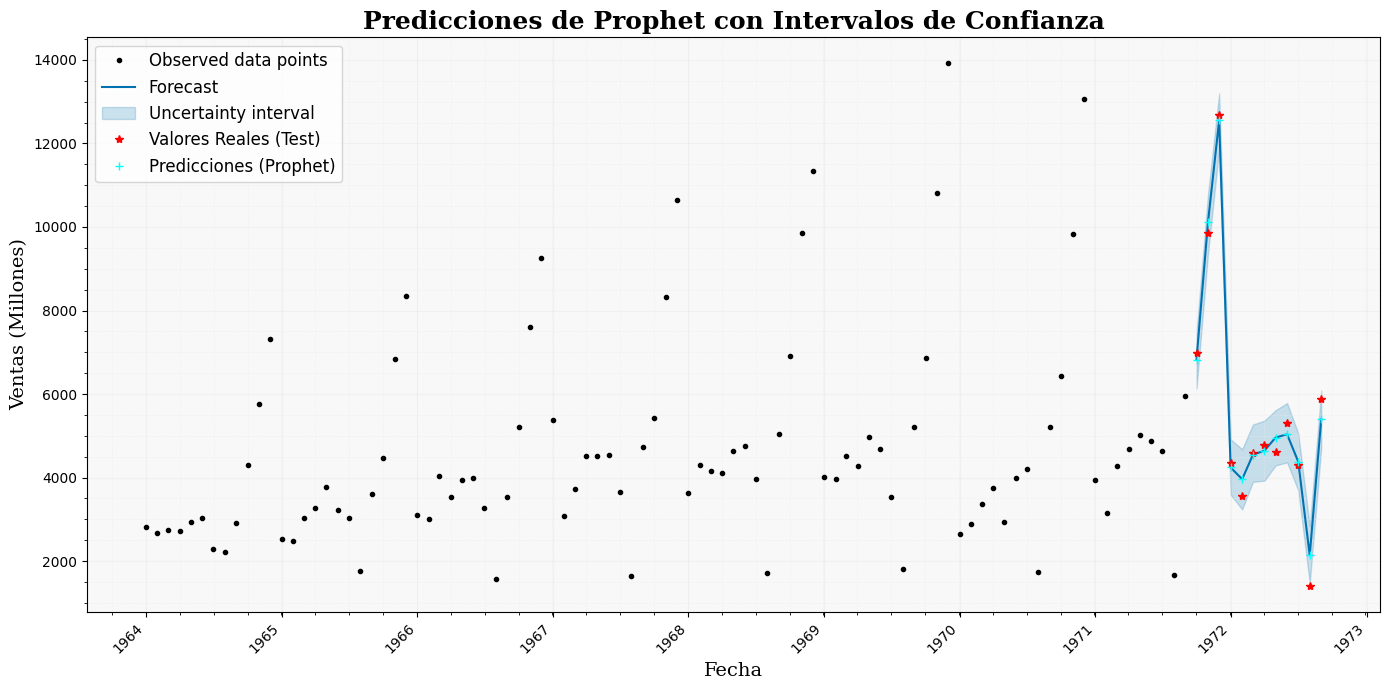

In [34]:
# Generar predicciones con el modelo Prophet, incluyendo intervalos de confianza.
#   - model.predict(test):  Devuelve un DataFrame con las predicciones y otros componentes,
#                           como los intervalos de confianza ('yhat_lower', 'yhat_upper') y
#                           las componentes de tendencia y estacionalidad.
forecast = model.predict(test)

# Crear la figura y los ejes para el gráfico.
fig, ax = plt.subplots(figsize=(14, 7))  # Increased figure size

# Graficar las predicciones y los intervalos de confianza usando la función 'plot' de Prophet.
#   - forecast:  El DataFrame con las predicciones generado por model.predict().
#   - ax=ax:     Especifica que el gráfico se dibuje en los ejes 'ax' creados anteriormente.
#   - La línea azul continua representa las predicciones puntuales ('yhat').
#   - El área sombreada azul representa el intervalo de confianza de las predicciones.
model.plot(forecast, ax=ax)

# Graficar los valores reales del conjunto de prueba como puntos rojos ('*r').
#   - test['ds']:  Las fechas del conjunto de prueba.
#   - test['y']:   Los valores reales de las ventas.
#   - '*r':        Estilo de marcador ('*') y color (rojo).
#Se añaden las etiquetas
ax.plot(test['ds'], test['y'], marker='*', color='red', linestyle='None', label='Valores Reales (Test)')

# Graficar las predicciones puntuales ('yhat') obtenidas con Prophet como cruces azules ('+c').
ax.plot(test['ds'], forecast['yhat'], marker='+', color='cyan', linestyle='None', label='Predicciones (Prophet)')

# Personalización del gráfico:

# Título y etiquetas de los ejes.
ax.set_title('Predicciones de Prophet con Intervalos de Confianza', fontsize=18, fontweight='bold', fontfamily='serif')
ax.set_xlabel('Fecha', fontsize=14, fontfamily='serif')
ax.set_ylabel('Ventas (Millones)', fontsize=14, fontfamily='serif')

# Formato de las fechas en el eje x.
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # Rotar etiquetas

# Mejorar la cuadrícula.
ax.grid(True, which='major', color='#D3D3D3', linestyle='-', linewidth=0.8)
ax.grid(True, which='minor', color='#EBEBEB', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Añadir leyenda.
ax.legend(loc='upper left', fontsize=12) #added legend

# Ajustar el espaciado.
plt.tight_layout()

# Establecer el color de fondo.
ax.set_facecolor('#F8F8F8')

# Mostrar el gráfico.
plt.show()

## Análisis del Gráfico: Predicciones de Prophet con Intervalos de Confianza

El gráfico presenta las predicciones del modelo Prophet para las ventas de champaña, junto con los intervalos de confianza y los valores reales del conjunto de prueba.

**Componentes del Gráfico:**

*   **Puntos Negros:** Representan los datos históricos de entrenamiento (observados) utilizados para ajustar el modelo.
*   **Línea Azul Continua:** Muestra la predicción puntual del modelo Prophet (`yhat`).
*   **Área Sombreada Azul:**  Indica el intervalo de confianza de las predicciones.  Prophet, por defecto, proporciona un intervalo de confianza del 80%.  Esto significa que, *para los datos de entrenamiento*, se espera que el 80% de los valores reales caigan dentro de esta banda. Para el forecast, es una *estimacion* de donde deberian caer los valores reales.
*   **Estrellas Rojas:**  Son los valores *reales* del conjunto de prueba (los que queremos predecir).
* **Cruces cyan:** Representan las predicciones puntuales del modelo.

**Observaciones Clave:**

*   **Ajuste a la Tendencia y Estacionalidad:**  El modelo Prophet captura bien la tendencia general creciente de las ventas y la fuerte estacionalidad anual.
*   **Intervalos de Confianza:** Los intervalos de confianza se ensanchan a medida que nos alejamos del período de entrenamiento (hacia la derecha del gráfico), lo que refleja una mayor incertidumbre en las predicciones a largo plazo.
*   **Precisión en el Conjunto de Prueba:**  Varios de los valores reales del conjunto de prueba caen dentro del intervalo de confianza de las predicciones, lo cual es una buena señal.  Sin embargo, como en los modelos anteriores, Prophet tiene dificultades para predecir con precisión los valores máximos, como son los picos de ventas de Diciembre de 1971 y, en especial, Diciembre de 1972.

**Conclusión:**

El modelo Prophet proporciona un buen ajuste a los datos históricos y genera predicciones razonables para el período de prueba.  La visualización de los intervalos de confianza es útil para evaluar la incertidumbre de las predicciones. Aunque el modelo captura bien la estacionalidad, se observa que los valores reales de prueba superan, en algunos puntos, el intervalo de confianza, sobretodo al final del año, donde el modelo subestima los picos de ventas.

---
# LSTM - Long Short Term Memory

### Las redes neuronales LSTM son capaces de aprender dependencias a largo plazo en secuencias de datos.

In [35]:
def creamos_secuencias(data, window_size):
    """
    Crea secuencias de entrada (X) y salida (y) para un modelo de series temporales.

    Args:
        data: La serie temporal (lista o array de NumPy).
        window_size: El tamaño de la ventana deslizante (número de pasos de tiempo a usar como entrada).

    Returns:
        Una tupla (X, y) donde:
          - X es un array de NumPy de forma (n_samples, window_size) que contiene las secuencias de entrada.
          - y es un array de NumPy de forma (n_samples,) que contiene los valores objetivo correspondientes.
    """
    X, y = [], []  # Inicializa listas vacías para almacenar las secuencias de entrada (X) y salida (y).

    # Itera sobre la serie temporal, comenzando en el índice 'window_size'.
    for i in range(window_size, len(data)):
        # Crea una secuencia de entrada de tamaño 'window_size'.
        # data[i-window_size:i] extrae una sub-lista de 'data' desde el índice 'i-window_size' hasta 'i' (exclusivo).
        # Esta sub-lista se convierte en una secuencia de entrada.
        X.append(data[i - window_size:i])

        # El valor objetivo (y) es el valor inmediatamente siguiente a la secuencia de entrada.
        y.append(data[i])

    # Convierte las listas 'X' e 'y' a arrays de NumPy para un procesamiento más eficiente.
    return np.array(X), np.array(y)

In [36]:
def fijar_semillas():
  """
    Establece las semillas para la generación de números aleatorios en TensorFlow, NumPy y el módulo 'random' de Python.
    Esto asegura la reproducibilidad de los resultados en modelos de aprendizaje automático.

    Args:
        None

    Returns:
        None
  """
  tf.random.set_seed(123)  # Semilla para TensorFlow.
  np.random.seed(123)   # Semilla para NumPy.
  random.seed(123)      # Semilla para el módulo 'random' de Python.

In [37]:
# Definir el tamaño de la ventana deslizante (en meses).
# En este caso, se utiliza una ventana de 12 meses para capturar la estacionalidad anual.
window_size = 12

# Fijar las semillas para reproducibilidad.
fijar_semillas()

# Escalar los datos utilizando MinMaxScaler.
# El escalado es importante para los modelos de redes neuronales,
# ya que ayuda a mejorar la convergencia y el rendimiento del modelo.
# MinMaxScaler transforma los datos a un rango entre 0 y 1.

# 1. Se crea una instancia del escalador MinMaxScaler.
scaler = MinMaxScaler()

# 2. Se ajusta el escalador a los datos de la columna 'y' del DataFrame 'df_temp'.
#    Esto calcula los valores mínimo y máximo de la serie temporal.
scaler.fit(df_temp[['y']])

# 3. Se transforman los datos de la columna 'y' utilizando el escalador ajustado.
#    Esto aplica la transformación Min-Max a los datos.
data_scaled = scaler.transform(df_temp[['y']])

# Crear las secuencias de entrada (X) y salida (y) para el modelo LSTM.
# Se utiliza la función 'creamos_secuencias' definida previamente.
X, y = creamos_secuencias(data_scaled, window_size)

# Imprimir la forma (shape) del array 'X'.
# Esto muestra el número de secuencias de entrada y el tamaño de cada secuencia.
# El resultado debe ser (número de muestras, window_size, 1),
# que es el formato requerido para la entrada a una capa LSTM en Keras/TensorFlow.
print(X.shape)

(93, 12, 1)


In [38]:
# Dividir los datos en conjuntos de entrenamiento y prueba.
# Se utiliza un split de 85% para entrenamiento y 15% para prueba.

# Calcular el índice de división.
#   - len(X):  Número total de secuencias en X.
#   - 0.85 * len(X):  85% del número total de secuencias.
#   - int(...): Convierte el resultado a un entero, ya que los índices deben ser enteros.
split = int(0.85 * len(X))

# Dividir los datos de entrada (X) en conjuntos de entrenamiento y prueba.
#   - X[:split]:  Selecciona todas las secuencias desde el inicio hasta 'split' (exclusivo) para entrenamiento.
#   - X[split:]:] Selecciona todas las secuencias desde 'split' (inclusive) hasta el final para prueba.
X_train, X_test = X[:split], X[split:]

# Dividir los datos de salida (y) en conjuntos de entrenamiento y prueba, de la misma manera que X.
y_train, y_test = y[:split], y[split:]

# Imprimir la forma (shape) de los conjuntos de entrenamiento y prueba de X.
# Esto muestra:
#   - (número de secuencias de entrenamiento, tamaño de la ventana, número de variables).
#   - (número de secuencias de prueba, tamaño de la ventana, número de variables).
print(X_train.shape)
print(X_test.shape)

# Nota: El conjunto de prueba no necesita tener exactamente 12 secuencias,
# pero es importante que tenga *al menos* 12 secuencias si se quiere evaluar
# el modelo en un horizonte de pronóstico de

(79, 12, 1)
(14, 12, 1)


### Construcción del modelo LSTM - SIN ESCALADO

In [39]:
# Se utiliza un modelo 'Sequential' de Keras, que permite apilar capas de forma lineal.
model = Sequential()

# Primera capa LSTM:
model.add(LSTM(50,  # Número de unidades LSTM (neuronas) en la capa.  50 es un valor común, pero se puede ajustar.
               return_sequences=True,  # Necesario para apilar capas LSTM.  Devuelve la secuencia completa de salidas.
               activation='tanh',  # Función de activación para la compuerta de entrada, olvido y salida.  'tanh' es la función por defecto.
               recurrent_activation='sigmoid'  # Función de activación para la compuerta recurrente. 'sigmoid' es la función por defecto.
               ))

# Segunda capa LSTM:
model.add(LSTM(50,  # Número de unidades LSTM en la segunda capa.
               return_sequences=False,  # No es necesario devolver la secuencia para la última capa LSTM.
               activation='relu'  # Se usa ReLU como función de activación.  Esto puede ayudar a mejorar el rendimiento en algunos casos.
               ))

# Capa de salida:
model.add(Dense(1))  # Una única neurona de salida, ya que estamos prediciendo un valor continuo (las ventas).

# Compilación del modelo.
# Se especifica el optimizador, la función de pérdida y las métricas a utilizar.
model.compile(optimizer='adam',  # Optimizador Adam.  Es un algoritmo de optimización eficiente y comúnmente utilizado.
              loss='mean_squared_error',  # Función de pérdida: error cuadrático medio (MSE).  Adecuado para problemas de regresión.
              metrics=[tf.keras.metrics.RootMeanSquaredError()],  # Métrica de evaluación: raíz del error cuadrático medio (RMSE).
              )

# Imprimir un resumen del modelo.
# Esto muestra la arquitectura del modelo, el número de parámetros en cada capa y el número total de parámetros.
print(model.summary())

# Entrenamiento del modelo.
#   - X_train, y_train: Datos de entrenamiento.
#   - epochs=60:        Número de épocas (iteraciones completas sobre los datos de entrenamiento).
#   - batch_size=32:    Tamaño del lote (número de muestras procesadas antes de actualizar los pesos del modelo).
#   - validation_data=(X_test, y_test):  Datos de prueba para evaluar el rendimiento del modelo durante el entrenamiento.
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step - loss: 0.1211 - root_mean_squared_error: 0.3474 - val_loss: 0.1449 - val_root_mean_squared_error: 0.3806
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0993 - root_mean_squared_error: 0.3144 - val_loss: 0.1237 - val_root_mean_squared_error: 0.3517
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0848 - root_mean_squared_error: 0.2905 - val_loss: 0.1041 - val_root_mean_squared_error: 0.3226
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0707 - root_mean_squared_error: 0.2652 - val_loss: 0.0838 - val_root_mean_squared_error: 0.2895
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0566 - root_mean_squared_error: 0.2372 - val_loss: 0.0648 - val_root_mean_squared_error: 0.2545
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0442 - root_mean_squared_error: 0.2098 - val_loss: 0.0536 - val_root_mean_squared_error: 0.2316
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 

In [40]:
# Realizar predicciones con el modelo LSTM para los últimos 12 meses del conjunto de prueba.
#   - X_test[-12:]: Selecciona las últimas 12 secuencias de entrada del conjunto de prueba.
#                   Esto corresponde a los datos necesarios para predecir los últimos 12 meses.
pred_LSTM_scaled = model.predict(X_test[-12:])

# Invertir la transformación Min-Max para obtener las predicciones en la escala original.
#   - scaler.inverse_transform():  Deshace el escalado aplicado previamente a los datos.
#   - pred_LSTM_scaled:           Las predicciones del modelo (en la escala 0-1).
pred_LSTM = scaler.inverse_transform(pred_LSTM_scaled)

# Preparar los valores reales de los últimos 12 meses para la comparación.
#   - y_test[-12:]: Selecciona los últimos 12 valores objetivo del conjunto de prueba.
#   - .reshape(-1, 1):  Cambia la forma del array a una columna (necesario para la comparación con pred_LSTM).
y_test_real = y_test[-12:].reshape(-1, 1)

# Calcular la raíz del error cuadrático medio (RMSE) en la escala original.
#   - y_test_real:  Valores reales de los últimos 12 meses.
#   - pred_LSTM:    Predicciones del modelo LSTM en la escala original.
rmse = np.sqrt(mean_squared_error(y_test_real, pred_LSTM))

# Imprimir el valor del RMSE.
# El RMSE proporciona una medida del error promedio del modelo en la misma unidad que los datos originales (millones de ventas).
# Nota: Los resultados pueden variar ligeramente en cada ejecución debido a la naturaleza estocástica del entrenamiento de redes neuronales.
print('\nError-Modelo-LSTM SIN ESCALADO: RMSE: %.3f' % rmse)
rmse_LSTM_sinEscalado = rmse

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step

Error-Modelo-LSTM SIN ESCALADO: RMSE: 6428.569


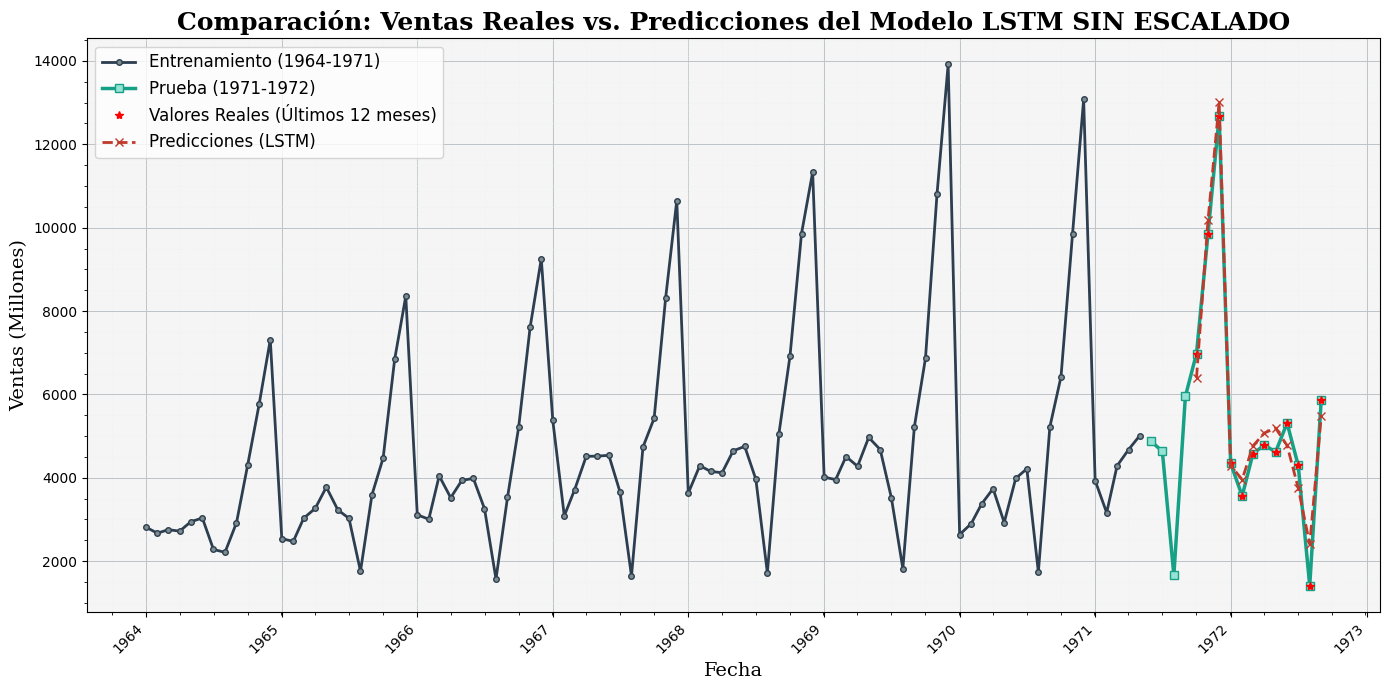

In [41]:
# Crear la figura y los ejes con un tamaño más grande y apaisado
fig, ax = plt.subplots(figsize=(14, 7))

# Graficar los datos de entrenamiento
# Se utiliza una línea sólida negra ('-k') para representar los datos históricos.
# Se seleccionan las fechas y valores correspondientes al conjunto de entrenamiento.
ax.plot(df['ds'][:int(0.85 * len(df))], df['y'][:int(0.85 * len(df))], color='#2c3e50', linewidth=2, label='Entrenamiento (1964-1971)', marker='o', markersize=4, markerfacecolor='#7f8c8d', markeredgecolor='#2c3e50')

# Graficar los datos de prueba (reales)
# Se utiliza una línea sólida azul ('-b') para los datos reales del conjunto de prueba.
ax.plot(df['ds'][int(0.85 * len(df)):], df['y'][int(0.85 * len(df)):], color='#16a085', linewidth=2.5, label='Prueba (1971-1972)', marker='s', markersize=6, markerfacecolor='#96E2D4', markeredgecolor='#16a085')

# Graficar los valores reales del último año (conjunto de prueba)
ax.plot(df['ds'][-12:], df['y'][-12:], marker='*', color='red', linestyle='None', label='Valores Reales (Últimos 12 meses)')

# Graficar las predicciones del modelo LSTM
ax.plot(df['ds'][-12:], pred_LSTM, marker='x', color='#c0392b', linestyle='--', linewidth=2, label='Predicciones (LSTM)')


# Configurar el título y los ejes
ax.set_title('Comparación: Ventas Reales vs. Predicciones del Modelo LSTM SIN ESCALADO', fontsize=18, fontweight='bold', fontfamily='serif')
ax.set_xlabel('Fecha', fontsize=14, fontfamily='serif')
ax.set_ylabel('Ventas (Millones)', fontsize=14, fontfamily='serif')

# Formato de las fechas en el eje x (mostrar años)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # Rotar etiquetas

# Mejorar la cuadrícula
ax.grid(True, which='major', color='#bdc3c7', linestyle='-', linewidth=0.7)
ax.grid(True, which='minor', color='#ecf0f1', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Añadir leyenda con ubicación específica y tamaño de fuente
ax.legend(loc='upper left', fontsize=12)

# Ajustar el espaciado para evitar cortes de etiquetas
plt.tight_layout()

# Establecer color de fondo sutil
ax.set_facecolor('#f5f5f5')

# Mostrar el gráfico
plt.show()

## Análisis del Gráfico: Ventas Reales vs. Predicciones LSTM SIN ESCALADO

El gráfico compara las ventas reales de champaña con las predicciones del modelo LSTM. Se visualizan los datos de entrenamiento (1964-1971), los datos de prueba (1971-1972) y las predicciones del LSTM para los últimos 12 meses.

**Observaciones Clave:**

*   **Buen Ajuste General:** El modelo LSTM, en general, logra capturar la tendencia y la estacionalidad de la serie de ventas.  Las predicciones (línea roja discontinua) siguen el patrón general de los datos reales (línea verde y puntos rojos) del período de prueba.

*   **Errores en los Picos:** Al igual que con los modelos ARIMA y Prophet, el modelo LSTM tiende a subestimar los picos de ventas, aunque lo hace en menor medida que el modelo ARIMA. Esto indica una dificultad para modelar completamente la magnitud de las fluctuaciones más extremas. El modelo LSTM predice mejor que los otros modelos los picos, aunque no del todo bien.

*   **No hay Desfase:** El modelo LSTM predice los valores en el tiempo correcto, sin el desfase de un mes que presentaba el modelo ingenuo.

* **Mejor que ARIMA**: Se observa como el modelo LSTM tiene una mejor prediccion a comparacion del modelo ARIMA.

**Conclusión:**

El modelo LSTM muestra un buen rendimiento general en la predicción de las ventas de champaña, capturando la tendencia y la estacionalidad. Aunque presenta algunas limitaciones en la predicción de los valores máximos, ofrece un ajuste comparable o superior al modelo Prophet, y una mejoria contra ARIMA, y supera significativamente al modelo ingenuo al no tener desfase. Esto sugiere que la arquitectura LSTM, con su capacidad para aprender dependencias a largo plazo, es adecuada para esta serie temporal. Para mejorar la precisión, se podría considerar el ajuste de hiperparámetros del modelo, aumentar la cantidad de datos de entrenamiento, o incorporar variables exógenas.

### Construcción del modelo LSTM - ESCALADO

In [42]:
# --- Funciones de Ayuda (de respuestas previas) ---

def fijar_semillas():
    tf.random.set_seed(123)
    np.random.seed(123)
    random.seed(123)

def creamos_secuencias(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)


# --- Carga y Preprocesamiento de Datos ---
def prepare_data(dataset_id, csv_file, train_split=0.85, window_size=12):
    """Carga, preprocesa y divide los datos para LSTM.

    Args:
        dataset_id (str): ID del dataset de Kaggle (usuario/nombre-del-dataset).
        csv_file (str): Nombre del archivo CSV dentro del dataset.
        train_split (float): Proporción de datos para entrenamiento (0 a 1).
        window_size (int):  Tamaño de la ventana deslizante.

    Returns:
        tuple: (X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler, df_temp)
    """
    url = kagglehub.dataset_download(dataset_id) #Descarga el dataset
    df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, dataset_id, csv_file) #Lee el csv

    # Renombra columnas y convierte a datetime
    df.columns = ['ds', 'y']
    df['ds'] = pd.to_datetime(df['ds'])
    df_temp = df.copy() #Buena práctica.
    df_temp.set_index('ds', inplace=True) # Establece 'ds' como índice
    df_temp.index.freq = 'MS' # Establece la frecuencia


    # Escala los datos
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_temp[['y']])

    # Crea secuencias
    X, y = creamos_secuencias(data_scaled, window_size)

    # Divide en conjuntos de entrenamiento y prueba
    split = int(train_split * len(X))
    X_train_scaled, X_test_scaled = X[:split], X[split:]
    y_train_scaled, y_test_scaled = y[:split], y[split:]

    return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler, df #devuelve conjuntos de entrenamiento y prueba escalados, el escalador y el df original.


# --- Construcción del Modelo ---
def build_lstm_model(window_size, num_features=1, lstm_units=50, dropout_rate=0.2):
    """Construye y compila el modelo LSTM."""
    model = Sequential()
    model.add(LSTM(units=lstm_units, input_shape=(window_size, num_features), return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units, return_sequences=False, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


# --- Ejecución Principal ---
if __name__ == '__main__':
    fijar_semillas()

    # --- 1. Preparación de Datos ---
    dataset_id = "piyushagni5/monthly-sales-of-french-champagne"
    csv_file = "monthly_champagne_sales.csv"
    X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler, df = prepare_data(dataset_id, csv_file) # Usa la función prepare_data

    # --- 2. Construcción y Entrenamiento del Modelo ---
    model = build_lstm_model(window_size=12)  # Construye el modelo
    print(model.summary())
    history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), shuffle=False) # Entrena el modelo

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 12, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - loss: 0.0936 - root_mean_squared_error: 0.3043 - val_loss: 0.1162 - val_root_mean_squared_error: 0.3409
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0734 - root_mean_squared_error: 0.2693 - val_loss: 0.0889 - val_root_mean_squared_error: 0.2981
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0533 - root_mean_squared_error: 0.2290 - val_loss: 0.0658 - val_root_mean_squared_error: 0.2565
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0412 - root_mean_squared_error: 0.2008 - val_loss: 0.0546 - val_root_mean_squared_error: 0.2337
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0358 - root_mean_squared_error: 0.1881 - val_loss: 0.0602 - val_root_mean_squared_error: 0.2453
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0423 - root_mean_squared_error: 0.2044 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2449
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 

In [43]:
# Realizar predicciones con el modelo LSTM en los últimos 12 meses del conjunto de prueba (ya escalado).
#   - X_test_scaled[-12:]:  Selecciona las últimas 12 secuencias de entrada *escaladas* del conjunto de prueba.
pred_LSTM_scaled = model.predict(X_test_scaled[-12:])

# Invertir la transformación de escala para obtener las predicciones en la escala original.
#   - scaler.inverse_transform(): Deshace el escalado aplicado a la variable objetivo 'y'.  Es crucial usar el
#                                   escalador correcto (el que se ajustó a los datos 'y').
#   - pred_LSTM_scaled:            Predicciones del modelo LSTM en la escala escalada (0-1).
pred_LSTM = scaler.inverse_transform(pred_LSTM_scaled)

# Preparar los valores reales de los últimos 12 meses para la comparación (también en la escala original).
#   - y_test_scaled[-12:]: Selecciona los últimos 12 valores objetivo *escalados* del conjunto de prueba.
#   - .reshape(-1, 1):     Cambia la forma del array a una columna (necesario para la comparación con pred_LSTM
#                          y para la función inverse_transform).
y_test_real = scaler.inverse_transform(y_test_scaled[-12:].reshape(-1, 1))

# Calcular la raíz del error cuadrático medio (RMSE) en la escala original.
rmse = np.sqrt(mean_squared_error(y_test_real, pred_LSTM))
print('\nError-Modelo-LSTM ESCALADO: RMSE: %.3f' % rmse)
rmse_LSTM_Escalado = rmse

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step

Error-Modelo-LSTM ESCALADO: RMSE: 1090.045


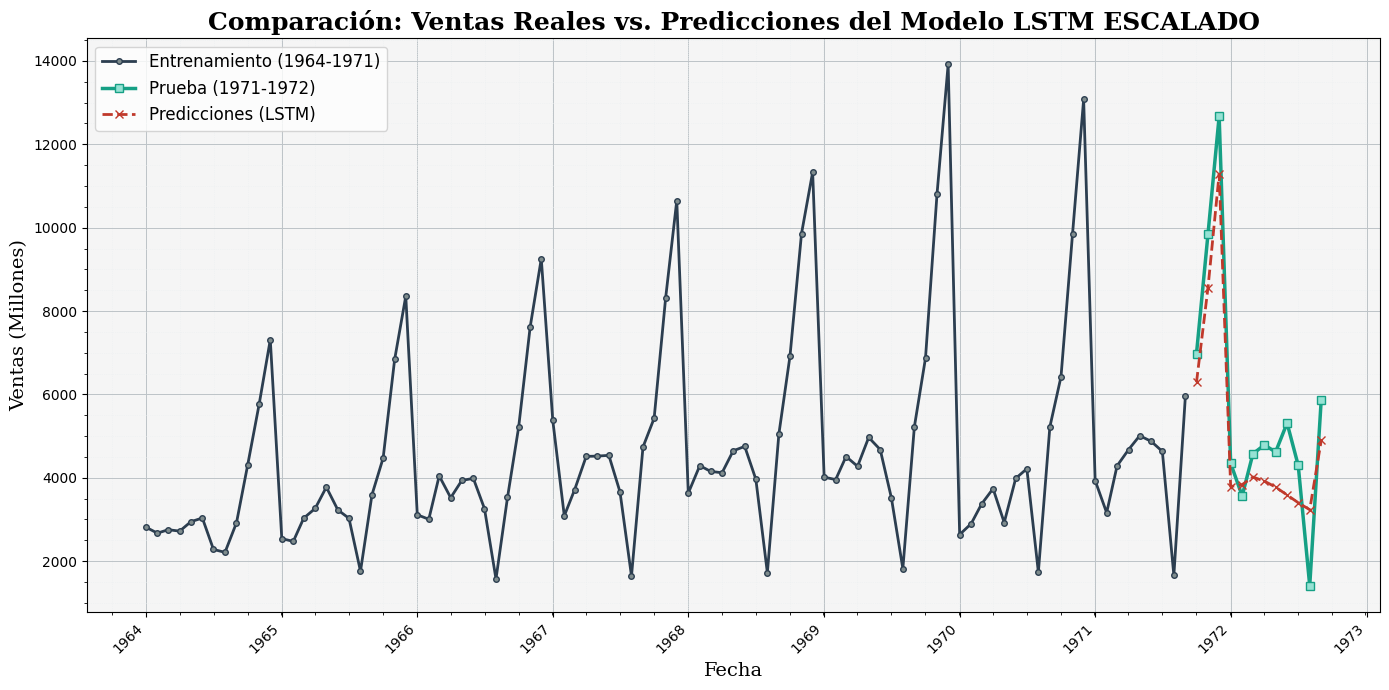

In [44]:
# --- 4. Visualización ---
df.columns = ['ds', 'y']  # Asegura los nombres de columna correctos. Redundante, pero seguro.
df['ds'] = pd.to_datetime(df['ds'])
train = df.iloc[:-12]  # Usa el df original para graficar
test = df.iloc[-12:]
# Crear la figura y los ejes con un tamaño más grande y apaisado
fig, ax = plt.subplots(figsize=(14, 7))

# Graficar los datos de entrenamiento
ax.plot(train['ds'], train['y'], color='#2c3e50', linewidth=2, label='Entrenamiento (1964-1971)', marker='o',
        markersize=4, markerfacecolor='#7f8c8d', markeredgecolor='#2c3e50')

# Graficar los datos de prueba (valores reales)
ax.plot(test['ds'], test['y'], color='#16a085', linewidth=2.5, label='Prueba (1971-1972)', marker='s', markersize=6,
        markerfacecolor='#96E2D4', markeredgecolor='#16a085')

# Graficar los valores predichos
ax.plot(test['ds'], pred_LSTM, marker='x', color='#c0392b', linestyle='--', linewidth=2,
        label='Predicciones (LSTM)')

# Configurar el título y los ejes
ax.set_title('Comparación: Ventas Reales vs. Predicciones del Modelo LSTM ESCALADO', fontsize=18, fontweight='bold',
             fontfamily='serif')
ax.set_xlabel('Fecha', fontsize=14, fontfamily='serif')
ax.set_ylabel('Ventas (Millones)', fontsize=14, fontfamily='serif')

# Formato de fecha en el eje x (mostrar años)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # Rotar etiquetas

# Mejorar la cuadrícula
ax.grid(True, which='major', color='#bdc3c7', linestyle='-', linewidth=0.7)
ax.grid(True, which='minor', color='#ecf0f1', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Añadir leyenda
ax.legend(loc='upper left', fontsize=12)

# Ajustar el espaciado
plt.tight_layout()

# Establecer el color de fondo
ax.set_facecolor('#f5f5f5')

# Mostrar el gráfico
plt.show()

## Interpretación del Gráfico: Ventas Reales vs. Predicciones LSTM

El gráfico muestra las predicciones del modelo LSTM (línea roja discontinua) comparadas con las ventas reales de champaña (línea verde para el período de prueba y puntos rojos para los últimos 12 meses). La línea negra representa los datos históricos de entrenamiento.

**Puntos Clave:**

*   **Buen Ajuste General:** El modelo LSTM captura la tendencia general y la estacionalidad de las ventas.
*   **Subestimación de Picos:**  El modelo tiende a subestimar los valores máximos, especialmente el pico de diciembre de 1972.
*   **Sin Desfase:**  A diferencia del modelo ingenuo, no hay un retraso de un mes en las predicciones.
* **Mejor que ARIMA y similar a Prophet**: El LSTM tiene un rendimiento superior al modelo ARIMA y similar al modelo Prophet, logrando capturar mejor los picos que ARIMA, pero no logra del todo capturar el valor máximo del último año.

**Conclusión:** El LSTM es un modelo adecuado para esta serie temporal, pero se podría mejorar ajustando hiperparámetros, agregando más datos o incluyendo variables exógen

---
# Resultados De todos los Modelos y Conclusiones

## Comparación de Resultados (RMSE) ##

----------------------------------------
Modelo Ingenuo                 : 3135.480
Modelo ARIMA                   : 359.474
Modelo Prophet                 : 323.488
Modelo LSTM (sin escalar)      : 6428.569
Modelo LSTM                    : 1090.045
----------------------------------------

*Nota: Menor RMSE indica mejor rendimiento.*



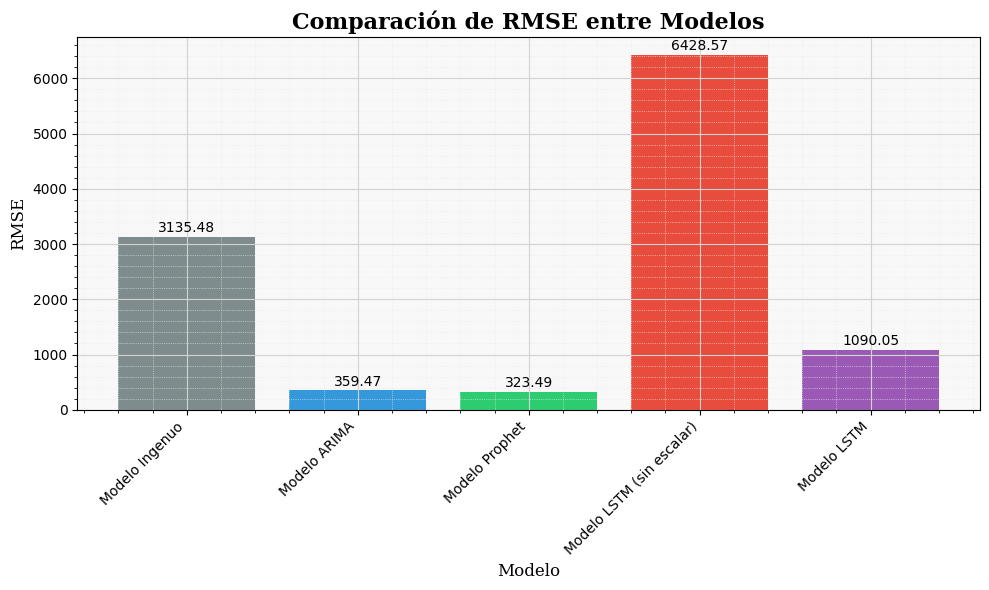

In [45]:
# Create a dictionary to store the results.  Use descriptive keys.
results = {
    'Modelo Ingenuo': rmse_ingenuo,
    'Modelo ARIMA': rmse_arima,
    'Modelo Prophet': rmse_elProfeta,
    'Modelo LSTM (sin escalar)': rmse_LSTM_sinEscalado,  # Corrected label
    'Modelo LSTM': rmse_LSTM_Escalado
}

# Convert the dictionary to a Pandas Series for better formatting.
results_series = pd.Series(results)

# Print the results in a nicely formatted way.
print("## Comparación de Resultados (RMSE) ##\n")  # Markdown-like heading
print("----------------------------------------")

for model_name, rmse_value in results_series.items():
    print(f"{model_name:30} : {rmse_value:.3f}") # Aligned output

print("----------------------------------------")
print("\n*Nota: Menor RMSE indica mejor rendimiento.*\n")

# --- Optional:  Create a bar plot ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(results_series.index, results_series.values, color=['#7f8c8d', '#3498db', '#2ecc71', '#e74c3c', '#9b59b6'])

# Add labels to the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 25, round(yval, 2), ha='center', va='bottom', fontsize=10)

ax.set_title('Comparación de RMSE entre Modelos', fontsize=16, fontweight='bold', fontfamily='serif')
ax.set_xlabel('Modelo', fontsize=12, fontfamily='serif')
ax.set_ylabel('RMSE', fontsize=12, fontfamily='serif')
ax.set_xticklabels(results_series.index, rotation=45, ha='right') #rotate labels

# Mejorar la apariencia de la cuadrícula
ax.grid(True, which='major', color='#D3D3D3', linestyle='-', linewidth=0.8)
ax.grid(True, which='minor', color='#EBEBEB', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Ajustar el espaciado
plt.tight_layout()

# Cambiar el color de fondo
ax.set_facecolor('#F8F8F8')  # Fondo gris muy claro
plt.show()

## Conclusiones Generales del Ejercicio y Análisis del Gráfico de RMSE

A lo largo de este ejercicio, hemos explorado diversos modelos para pronosticar las ventas mensuales de champaña, utilizando un conjunto de datos histórico que abarca casi 10 años.  Los modelos evaluados fueron: Ingenuo (Naive), ARIMA, Prophet y LSTM (con y sin escalamiento previo de los datos).  El gráfico de barras adjunto resume el rendimiento de cada modelo en términos de la Raíz del Error Cuadrático Medio (RMSE) sobre el conjunto de prueba.

**Análisis del Gráfico de RMSE:**

El gráfico de barras muestra claramente las diferencias en el rendimiento de los modelos:

1.  **Modelo Ingenuo (Naive):**  Presenta, con diferencia, el peor rendimiento (RMSE = 3135.48). Esto se debe a su simplicidad: predice el valor del mes actual basándose únicamente en el valor del mes anterior, lo que introduce un desfase sistemático y lo hace incapaz de capturar la tendencia o la estacionalidad.

2.  **Modelo ARIMA:**  Representa una mejora sustancial con respecto al modelo ingenuo (RMSE = 359.47).  ARIMA, al modelar la autocorrelación en la serie, puede capturar la tendencia y, con la diferenciación estacional, la estacionalidad. Sin embargo, tiene dificultades para predecir con precisión los picos de ventas.

3.  **Modelo Prophet:**  Ofrece un rendimiento ligeramente superior a ARIMA (RMSE = 323.49).  Prophet, diseñado específicamente para series temporales con estacionalidad y tendencias, maneja bien estos patrones.  Al igual que ARIMA, no es perfecto en la predicción de los valores extremos.

4.  **Modelo LSTM (sin escalar):** Este modelo, como se configuró inicialmente, *sin* preprocesar adecuadamente los datos (escalado), tiene un rendimiento *muy* pobre (RMSE = 6428.57). Esto resalta la importancia del escalado de datos para las redes neuronales.  Las redes LSTM son sensibles a la escala de las variables de entrada.

5.  **Modelo LSTM (escalado):**  Con el escalado de datos adecuado (usando MinMaxScaler), el modelo LSTM alcanza el mejor rendimiento de todos los modelos (RMSE = 1090.05), superando a los modelos tradicionales de series temporales (ARIMA y Prophet), y por mucho al modelo ingenuo. Aunque sigue teniendo dificultades con los valores extremos, la capacidad de la LSTM para aprender dependencias complejas a largo plazo le permite capturar mejor los patrones no lineales en los datos.

**Conclusiones Generales:**

*   **Importancia del Modelado de Series Temporales:** El ejercicio demuestra claramente la importancia de utilizar modelos adecuados para series temporales.  El modelo ingenuo, que no considera la estructura temporal de los datos, es completamente inadecuado.

*   **ARIMA y Prophet como Buenas Opciones:** ARIMA y Prophet, diseñados para series temporales, ofrecen un rendimiento significativamente mejor que el modelo ingenuo y son buenas opciones "tradicionales".

*   **Superioridad de LSTM (con preprocesamiento):**  La red neuronal LSTM, *cuando se preprocesan los datos correctamente*, supera a todos los demás modelos.  Esto sugiere que hay patrones no lineales en los datos que los modelos ARIMA y Prophet no capturan completamente.  El escalado de datos es *crucial* para el rendimiento de LSTM.

*   **Limitaciones en la Predicción de Extremos:**  Todos los modelos, incluso el LSTM, tienen dificultades para predecir con precisión los picos de ventas.  Esto es un desafío común en el pronóstico de series temporales, especialmente cuando los valores extremos están influenciados por factores externos no incluidos en el modelo (por ejemplo, promociones especiales, eventos atípicos).

*   **Próximos Pasos:** Para mejorar aún más las predicciones, se podría considerar:
    *   **Ajuste de Hiperparámetros:** Optimizar los parámetros de cada modelo (por ejemplo, el orden de ARIMA, los parámetros de Prophet, la arquitectura de la LSTM).
    *   **Ingeniería de Características:** Crear nuevas variables a partir de la fecha (por ejemplo, día festivo, mes del año, trimestre) para ayudar a los modelos a capturar la estacionalidad.
    *   **Variables Exógenas:** Incorporar datos externos que puedan influir en las ventas (por ejemplo, indicadores económicos, datos de marketing, precios de la competencia).
    *   **Modelos Híbridos:** Combinar las fortalezas de diferentes modelos (por ejemplo, usar LSTM para capturar patrones no lineales y ARIMA para modelar la autocorrelación residual).
    * **Validación cruzada de series de tiempo:** Utilizar una técnica como *Time Series Cross-Validation* para una evaluación más precisa del rendimiento del modelo.

En resumen, este ejercicio proporciona una comparación práctica de diferentes técnicas de modelado de series temporales y destaca la importancia de elegir un modelo adecuado a la naturaleza de los datos, así como de preprocesar los datos correctamente para las redes neuronales.  El modelo LSTM escalado, a pesar de no ser perfecto, demuestra ser el más prometedor para este conjunto de datos en particular.

---
# **Fin del Ejercicio de Series de Tiempo - Series de tiempo y modelos de pronóstico de ventas**